In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

# understat import for understat api
import asyncio
import json
import aiohttp
from understat import Understat
year = ['2014','2015','2016','2017','2018','2019','2020']

import sys,importlib
# importlib.reload(sys.modules['function'])
from function import *

modèle regression logistique 
* résultat :
    * européen
    * non-européen

* Critère défense : 
    * valeur
    * taille
    * vitesse
    * expérience
    * (poid)

# Projet 8 - Arsenal, européen ?

Préparation des données

In [2]:
ligue_df_all = []
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        for i in year:
            table = await understat.get_league_table("Serie_A", i)
            ligue_df = pd.DataFrame(data=table)
            ligue_df['year'] = i
            ligue_df['Rank'] = ligue_df.index
            ligue_df_all.append(ligue_df)
        df = pd.concat(ligue_df_all)
        return df
loop = asyncio.get_event_loop()
import nest_asyncio
nest_asyncio.apply()
df_ligue = loop.run_until_complete(main())
df_ligue.columns = df_ligue.iloc[0]
df_ligue = df_ligue[1:] 
df_ligue.rename(columns={'2014':'Years',0:'Rank'},inplace=True)
df_ligue = df_ligue[['Rank','Team','M','W','D','L','G','GA','PTS','xG','xGA','xPTS','Years']]

In [3]:
df_ligue['Team'].unique()

array(['Juventus', 'Roma', 'Lazio', 'Fiorentina', 'Napoli', 'Genoa',
       'Sampdoria', 'Inter', 'Torino', 'AC Milan', 'Palermo', 'Sassuolo',
       'Verona', 'Chievo', 'Empoli', 'Udinese', 'Atalanta', 'Cagliari',
       'Parma', 'Cesena', 'Team', 'Bologna', 'Carpi', 'Frosinone',
       'Crotone', 'Pescara', 'SPAL 2013', 'Benevento',
       'Parma Calcio 1913', 'Lecce', 'Brescia', 'Spezia'], dtype=object)

In [11]:
df_ligue[df_ligue['Team'] == 'Parma']

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years
19,19,Parma,38,6,8,24,33,75,26,31.77,60.74,31.52,2014


In [21]:
euro_crew = ['juventus-turin', 'as-rom', 'lazio-rom', 'ac-florenz','ssc-neapel', 'genua-cfc', 'sampdoria-genua', 'inter-mailand','fc-turin','ac-mailand',
             'palermo-fc','us-sassuolo','hellas-verona','chievo-verona','fc-empoli','udinese-calcio','atalanta-bergamo','cagliari-calcio','parma-calcio-1913','cesena-fc',
             'fc-bologna','carpi-fc-1909','frosinone-calcio','fc-crotone','delfino-pescara-1936','spal','benevento-calcio','us-lecce','brescia-calcio','spezia-calcio']
num = ['506','12','398','430','6195','252','1038','46','416','5','458','6574','276','862','749','410','800','1390','130','1429','1025','4102','8970','4083','2921','2722','4171','1005','19','3522']
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

In [22]:
for eq,num_eq in zip(euro_crew,num):
    print(eq,num_eq)

juventus-turin 506
as-rom 12
lazio-rom 398
ac-florenz 430
ssc-neapel 6195
genua-cfc 252
sampdoria-genua 1038
inter-mailand 46
fc-turin 416
ac-mailand 5
palermo-fc 458
us-sassuolo 6574
hellas-verona 276
chievo-verona 862
fc-empoli 749
udinese-calcio 410
atalanta-bergamo 800
cagliari-calcio 1390
parma-calcio-1913 130
cesena-fc 1429
fc-bologna 1025
carpi-fc-1909 4102
frosinone-calcio 8970
fc-crotone 4083
delfino-pescara-1936 2921
spal 2722
benevento-calcio 4171
us-lecce 1005
brescia-calcio 19
spezia-calcio 3522


In [25]:
header_crew = ['Position', 'Valeur maximum']
df_crew = []

for eq,num_eq in zip(euro_crew,num):
    for k in year:
        try:
            print(eq,k)
            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            value = soup.find('div',{'class':'large-8 columns'}).div.find('div',{'class':'responsive-table'}).table.tbody.find_all('tr')
            list_attribute = []
            list_money_money = []
            table_list = []
            for i in value:
                try:
                    money = i.find('td',{'class':'rechts hauptlink'}).text
                    if 'K' in money:
                        list_money_money.append(float(money.split(' ')[0])/1000)
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)
                    elif 'mio' in money:
                        list_money_money.append(float(money.split(' ')[0].replace(',','.')))
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)

                except AttributeError:
                    continue

            table_list.append(list_attribute)
            table_list.append(list_money_money)
            value_crew = pd.DataFrame(data=table_list,index=header_crew)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            value_crew = value_crew.T
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            value_crew = value_crew.reset_index()

            #print(value_crew)
            value_crew_max = value_crew.sort_values(by='Valeur maximum',ascending=False)
            gardien = value_crew_max[value_crew_max['Position'] == 'Gardien de but'].iloc[0:1]
            defenseur = value_crew_max[(value_crew_max['Position'] == 'Défenseur central')|(value_crew_max['Position'] == 'Arrière gauche')|(value_crew_max['Position'] == 'Arrière droit')].iloc[0:1]
            milieu = value_crew_max[(value_crew_max['Position'] == 'Milieu défensif')|(value_crew_max['Position'] == 'Milieu central')|(value_crew_max['Position'] == 'Milieu offensif')].iloc[0:1]
            attaquant = value_crew_max[(value_crew_max['Position'] == 'Ailier droit')|(value_crew_max['Position'] == 'Ailier gauche')|(value_crew_max['Position'] == 'Avant-centre')].iloc[0:1]
            total = value_crew_max.iloc[0:1]

            gardien['Position'] = 'Gardien'
            defenseur['Position'] = 'Défense'
            milieu['Position'] = 'Milieu'
            attaquant['Position'] = 'Attaquant'
            total['Position'] = 'Total'
            value_crew_all = pd.concat([gardien,defenseur,milieu,attaquant,total])
            df_crew.append(value_crew_all)
            
        except TimeoutError:
            print('k')
            print(eq,k)
            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            value = soup.find('div',{'class':'large-8 columns'}).div.find('div',{'class':'responsive-table'}).table.tbody.find_all('tr')
            list_attribute = []
            list_money_money = []
            table_list = []
            for i in value:
                try:
                    money = i.find('td',{'class':'rechts hauptlink'}).text
                    if 'K' in money:
                        list_money_money.append(float(money.split(' ')[0])/1000)
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)
                    elif 'mio' in money:
                        list_money_money.append(float(money.split(' ')[0].replace(',','.')))
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)

                except AttributeError:
                    continue

            table_list.append(list_attribute)
            table_list.append(list_money_money)
            value_crew = pd.DataFrame(data=table_list,index=header_crew)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            value_crew = value_crew.T
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            value_crew = value_crew.reset_index()

            #print(value_crew)
            value_crew_max = value_crew.sort_values(by='Valeur maximum',ascending=False)
            gardien = value_crew_max[value_crew_max['Position'] == 'Gardien de but'].iloc[0:1]
            defenseur = value_crew_max[(value_crew_max['Position'] == 'Défenseur central')|(value_crew_max['Position'] == 'Arrière gauche')|(value_crew_max['Position'] == 'Arrière droit')].iloc[0:1]
            milieu = value_crew_max[(value_crew_max['Position'] == 'Milieu défensif')|(value_crew_max['Position'] == 'Milieu central')|(value_crew_max['Position'] == 'Milieu offensif')].iloc[0:1]
            attaquant = value_crew_max[(value_crew_max['Position'] == 'Ailier droit')|(value_crew_max['Position'] == 'Ailier gauche')|(value_crew_max['Position'] == 'Avant-centre')].iloc[0:1]
            total = value_crew_max.iloc[0:1]

            gardien['Position'] = 'Gardien'
            defenseur['Position'] = 'Défense'
            milieu['Position'] = 'Milieu'
            attaquant['Position'] = 'Attaquant'
            total['Position'] = 'Total'
            value_crew_all = pd.concat([gardien,defenseur,milieu,attaquant,total])
            df_crew.append(value_crew_all)
            continue
df_value_max = pd.concat(df_crew)

juventus-turin 2014


<ipython-input-25-533fd743d504>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total['Position'] = 'Total'


juventus-turin 2015
juventus-turin 2016
juventus-turin 2017
juventus-turin 2018
juventus-turin 2019
juventus-turin 2020
as-rom 2014
as-rom 2015
as-rom 2016
as-rom 2017
as-rom 2018
as-rom 2019
as-rom 2020
lazio-rom 2014
lazio-rom 2015
lazio-rom 2016
lazio-rom 2017
lazio-rom 2018
lazio-rom 2019
lazio-rom 2020
ac-florenz 2014
ac-florenz 2015
ac-florenz 2016
ac-florenz 2017
ac-florenz 2018
ac-florenz 2019
ac-florenz 2020
ssc-neapel 2014
ssc-neapel 2015
ssc-neapel 2016
ssc-neapel 2017
ssc-neapel 2018
ssc-neapel 2019
ssc-neapel 2020
genua-cfc 2014
genua-cfc 2015
genua-cfc 2016
genua-cfc 2017
genua-cfc 2018
genua-cfc 2019
genua-cfc 2020
sampdoria-genua 2014
sampdoria-genua 2015
sampdoria-genua 2016
sampdoria-genua 2017
sampdoria-genua 2018
sampdoria-genua 2019
sampdoria-genua 2020
inter-mailand 2014
inter-mailand 2015
inter-mailand 2016
inter-mailand 2017
inter-mailand 2018
inter-mailand 2019
inter-mailand 2020
fc-turin 2014
fc-turin 2015
fc-turin 2016
fc-turin 2017
fc-turin 2018
fc-turin 201

In [27]:
df_crew = []
header_crew = ['Positions', 'Âge', 'Valeur marchande', 'Valeur marchande moyenne']
for eq,num_eq in zip(euro_crew,num):
    print(eq)
    if eq == 'thonon-evian-grand-geneve-fc':
        for k in year[:3]:

            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            body = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tbody.find_all('td')
            foot = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tfoot.find_all('tr')
            x = 0
            table_list = [header_crew]
            body_list = []
            for g in body:

                body_list.append(g.text)
                x = x + 1
                if x == 5:
                    table_list.append(body_list[1:])
                    body_list = []
                    x = 0

            for h in foot: 
                foot_list = []
                for gk2 in h.find_all('td'):
                    foot_list.append(gk2.text)
                table_list.append(foot_list)

            value_crew = pd.DataFrame(data=table_list)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            #print(value_crew,k)
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            df_crew.append(value_crew)
    else:
        for k in year:

            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            body = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tbody.find_all('td')
            foot = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tfoot.find_all('tr')
            x = 0
            table_list = [header_crew]
            body_list = []
            for g in body:

                body_list.append(g.text)
                x = x + 1
                if x == 5:
                    table_list.append(body_list[1:])
                    body_list = []
                    x = 0

            for h in foot: 
                foot_list = []
                for gk2 in h.find_all('td'):
                    foot_list.append(gk2.text)
                table_list.append(foot_list)

            value_crew = pd.DataFrame(data=table_list)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            #print(value_crew,k)
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            df_crew.append(value_crew)
#print(df_crew)
df_euro_all = pd.concat(df_crew)

juventus-turin
as-rom
lazio-rom
ac-florenz
ssc-neapel
genua-cfc
sampdoria-genua
inter-mailand
fc-turin
ac-mailand
palermo-fc
us-sassuolo
hellas-verona
chievo-verona
fc-empoli
udinese-calcio
atalanta-bergamo
cagliari-calcio
parma-calcio-1913
cesena-fc
fc-bologna
carpi-fc-1909
frosinone-calcio
fc-crotone
delfino-pescara-1936
spal
benevento-calcio
us-lecce
brescia-calcio
spezia-calcio


In [28]:
df_euro_all

,Positions,Âge,Valeur marchande,Valeur marchande moyenne,Years,Crew
1,Gardien,"25,83","2,80 mio. €",467 K €,2014,juventus-turin
2,Défense,"26,58","81,50 mio. €","6,79 mio. €",2014,juventus-turin
3,Milieu de terrain,"25,30","170,40 mio. €","17,04 mio. €",2014,juventus-turin
4,Attaquant,"26,29","74,30 mio. €","10,61 mio. €",2014,juventus-turin
5,Total:,"26,03","329,00 mio. €","9,40 mio. €",2014,juventus-turin
...,...,...,...,...,...,...
1,Gardien,"26,80","5,03 mio. €","1,01 mio. €",2020,spezia-calcio
2,Défense,"24,00","18,65 mio. €","1,33 mio. €",2020,spezia-calcio
3,Milieu de terrain,"24,17","30,00 mio. €","2,50 mio. €",2020,spezia-calcio
4,Attaquant,"25,25","18,00 mio. €","2,25 mio. €",2020,spezia-calcio


In [29]:
df_euro_all.rename(columns={'Valeur marchande':'Valeur marchande (millions)','Valeur marchande moyenne':'Valeur marchande moyenne (millions)'},inplace=True)

In [30]:
# df_euro_all[['Position', 'Valeur maximum', 'Valeur marchande (millions)','Valeur marchande moyenne (millions)', 'Years', 'Crew']]

In [31]:
df_euro_all = df_euro_all[df_euro_all['Valeur marchande (millions)'] != '-']

In [32]:
df_euro_all['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande (millions)']]
df_euro_all['Valeur marchande moyenne (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande moyenne (millions)']]

In [33]:
for i in df_euro_all['Valeur marchande (millions)']:
    if ' mrd. €' in i:
        print(float(i.replace(' mrd. €','')))

In [34]:
df_euro_all['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande (millions)']]

In [35]:
df_euro_all['Valeur marchande (millions)'] = [i.replace(' mio. €','') for i in df_euro_all['Valeur marchande (millions)']]
df_euro_all['Valeur marchande moyenne (millions)'] = [i.replace(' mio. €','') for i in df_euro_all['Valeur marchande moyenne (millions)']]

In [36]:
list_vald = []
for i in df_euro_all['Valeur marchande (millions)']:
    if ' mrd. €' in i:
        list_vald.append(float(i.replace(' mrd. €',''))*1000)
    elif ' K €' in i:
        list_vald.append(float(i.replace(' K €',''))/1000)        
    else:
        list_vald.append(float(i))
    
df_euro_all['Valeur marchande (millions)'] = list_vald

In [37]:
list_vald = []
for i in df_euro_all['Valeur marchande moyenne (millions)']:
    if ' mrd. €' in i:
        list_vald.append(float(i.replace(' mrd. €',''))*1000)
    elif ' K €' in i:
        list_vald.append(float(i.replace(' K €',''))/1000)        
    else:
        list_vald.append(float(i))
    
df_euro_all['Valeur marchande moyenne (millions)'] = list_vald

In [38]:
df_euro_all['Positions'] = [i.replace(':','') for i in df_euro_all['Positions']]

In [39]:
df_euro_all['Crew'] = [i.replace('-',' ') for i in df_euro_all['Crew']]
df_euro_all['Crew'] = [i.replace('fc','') for i in df_euro_all['Crew']]

In [40]:
df_ligue = df_ligue[df_ligue['Team'] != 'Team']

In [43]:
df_ligue.to_csv('ligue_serieA.csv',index=False)
df_value_max.to_csv('all_value_max_serieA.csv',index=False)

In [44]:
df_euro_all.to_csv('all_value_euro_serieA.csv',index=False)

In [36]:
ligue_player_all = []
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        for i in year:
            table = await understat.get_league_players("Serie_A", i)
            ligue_player = pd.DataFrame(data=table)
            ligue_player['year'] = i
            ligue_player_all.append(ligue_player)
        df = pd.concat(ligue_player_all)
        return df
loop = asyncio.get_event_loop()

In [37]:
import nest_asyncio
nest_asyncio.apply()
df_ligue_player = loop.run_until_complete(main())

In [38]:
df_ligue_player.head()

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup,year
0,1513,Mauro Icardi,36,2897,22,20.0405349470675,6,4.607649671845138,121,34,4,0,F S,Inter,18,16.234040889889002,23.24298907443881,4.910617297515273,2014
1,1955,Luca Toni,38,3228,22,21.20476857945323,2,2.9142517521977425,125,27,3,0,F S,Verona,18,16.63697560504079,18.81056160479784,3.1060418942943215,2014
2,3848,Carlos Tévez,32,2594,20,13.372144434601068,7,5.016579711809754,114,61,6,0,F M S,Juventus,18,10.327028889209032,20.007632218301296,8.90753672271967,2014
3,1293,Gonzalo Higuaín,37,2786,18,21.097411520779133,7,4.082173843868077,113,49,5,0,F S,Napoli,15,15.768319822847843,22.71157662756741,4.917353065684438,2014
4,2014,Jérémy Menez,33,2713,16,10.936868623830378,4,4.379691986367106,78,46,3,1,F M S,AC Milan,8,4.846598354168236,13.755915867164731,6.889687442686409,2014


In [39]:
# print(df_ligue_player.dtypes)
# df_ligue_player.columns

In [40]:
df_ligue_player['xG'] = [np.around(float(i),decimals=4) for i in df_ligue_player['xG']]
df_ligue_player['xA'] = [np.around(float(i),decimals=4) for i in df_ligue_player['xA']]


In [41]:
column = ['games', 'time', 'goals',  'assists', 
       'shots', 'key_passes', 'yellow_cards', 'red_cards','npg', 'year']
for i in column:
    df_ligue_player[i] = df_ligue_player[i].astype(int)

In [42]:
column = ['xG','xA','npxG', 'xGChain', 'xGBuildup']
for i in column:
    df_ligue_player[i] = [np.around(float(i),decimals=4) for i in df_ligue_player[i]]
    

In [43]:
# df_ligue_player[df_ligue_player['team_title'] == 'Montpellier']

In [44]:
df_ligue_player.to_csv('all_player_serieA.csv',index=False)

# Analyse

In [45]:
df_player = pd.read_csv('all_player_serieA.csv',sep=',')
df_euro = pd.read_csv('all_value_euro_serieA.csv',sep=',')
value_max = pd.read_csv('all_value_max_serieA.csv',sep=',')

In [89]:
value_max['Crew'].unique()

array(['juventus-turin', 'as-rom', 'lazio-rom', 'ac-florenz',
       'ssc-neapel', 'genua-cfc', 'sampdoria-genua', 'inter-mailand',
       'fc-turin', 'ac-mailand', 'palermo-fc', 'us-sassuolo',
       'hellas-verona', 'chievo-verona', 'fc-empoli', 'udinese-calcio',
       'atalanta-bergamo', 'cagliari-calcio', 'parma-calcio-1913',
       'cesena-fc', 'fc-bologna', 'carpi-fc-1909', 'frosinone-calcio',
       'fc-crotone', 'delfino-pescara-1936', 'spal', 'benevento-calcio',
       'us-lecce', 'brescia-calcio', 'spezia-calcio'], dtype=object)

In [8]:
ligue = pd.read_csv('ligue_serieA.csv',sep=',')

In [9]:
# column_2019 = ligue.columns
# psg_2019 = []
# for i in column_2019:
#     if (i == 'Rank')|(i == 'Team')|(i == 'Years'):
#         psg_2019.append(ligue[(ligue['Years'] == 2019)&((ligue['Team'] == 'Paris Saint Germain')|(ligue['Team'] == 'Strasbourg'))][i])
#     else:
#         psg_2019.append(ligue[(ligue['Years'] == 2019)&((ligue['Team'] == 'Paris Saint Germain')|(ligue['Team'] == 'Strasbourg'))][i]*1.4074074074074074)

# psg_2019_df = pd.DataFrame(data=psg_2019)
# psg_2019_df = psg_2019_df.T

In [29]:
# euro_2019 = []
# for i in column_2019:
#     if (i == 'Rank')|(i == 'Team')|(i == 'Years'):
#         euro_2019.append(pd.concat([ligue[ligue['Years'] == 2019].iloc[1:10][i],ligue[ligue['Years'] == 2019].iloc[11:][i]]))
#     else:
#         euro_2019.append(pd.concat([ligue[ligue['Years'] == 2019].iloc[1:10][i]*1.3571428571428572,ligue[ligue['Years'] == 2019].iloc[11:][i]*1.3571428571428572]))
# euro_2019_df = pd.DataFrame(data=euro_2019)
# euro_2019_df = euro_2019_df.T

In [11]:
# euro_ligue_without = ligue[ligue['Years'] != 2019]
ligue_corr = ligue
# ligue_corr = ligue_corr.sort_index()

In [12]:
list_xG = []
for i,a in zip(list(ligue['xG']),list(ligue['G'])):
    #print(i,a)
    list_xG.append(np.around(int(a)/int(i),decimals=3))

list_xGA = []
for e,h in zip(list(ligue['xGA']),list(ligue['GA'])):
    list_xGA.append(np.around(int(h)/int(e),decimals=3))

list_xPTS = []
for e,h in zip(list(ligue['xPTS']),list(ligue['PTS'])):
    list_xPTS.append(np.around(int(h)/int(e),decimals=3))

ligue_corr['xG coef'] = list_xG
ligue_corr['xGA coef'] = list_xGA
ligue_corr['xPTS coef'] = list_xPTS

In [13]:
ligue_corr['M'] = [np.around(i,decimals=0) for i in ligue_corr['M']]
ligue_corr['W'] = [np.around(i,decimals=0) for i in ligue_corr['W']]
ligue_corr['D'] = [np.around(i,decimals=0) for i in ligue_corr['D']]
ligue_corr['L'] = [np.around(i,decimals=0) for i in ligue_corr['L']]
ligue_corr['G'] = [np.around(i,decimals=3) for i in ligue_corr['G']]
ligue_corr['GA'] = [np.around(i,decimals=3) for i in ligue_corr['GA']]
ligue_corr['PTS'] = [np.around(i,decimals=0) for i in ligue_corr['PTS']]
ligue_corr['xG'] = [np.around(i,decimals=3) for i in ligue_corr['xG']]
ligue_corr['xGA'] = [np.around(i,decimals=3) for i in ligue_corr['xGA']]
ligue_corr['xPTS'] = [np.around(i,decimals=3) for i in ligue_corr['xPTS']]
ligue_corr['xG coef'] = [np.around(i,decimals=3) for i in ligue_corr['xG coef']]
ligue_corr['xGA coef'] = [np.around(i,decimals=3) for i in ligue_corr['xGA coef']]

In [14]:
ligue_corr.to_csv('ligue_corrected.csv',index=False)

In [15]:
ligue_corr = pd.read_csv('ligue_corrected.csv',sep=',')

In [16]:
ligue_corr[ligue_corr['Years'] == 2014]

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef
0,1,Juventus,38,26,9,3,72,24,87,59.08,29.13,74.79,2014,1.220,0.828,1.176
1,2,Roma,38,19,13,6,54,31,70,50.85,36.79,62.16,2014,1.080,0.861,1.129
2,3,Lazio,38,21,6,11,71,38,69,62.00,35.87,67.79,2014,1.145,1.086,1.030
3,4,Fiorentina,38,18,10,10,61,46,64,60.67,48.50,61.11,2014,1.017,0.958,1.049
4,5,Napoli,38,18,9,11,70,54,63,64.50,34.37,70.72,2014,1.094,1.588,0.900
5,6,Genoa,38,16,11,11,62,47,59,57.32,60.37,50.55,2014,1.088,0.783,1.180
6,7,Sampdoria,38,13,17,8,48,42,56,47.59,48.37,52.85,2014,1.021,0.875,1.077
7,8,Inter,38,14,13,11,59,48,55,57.17,44.32,60.80,2014,1.035,1.091,0.917
8,9,Torino,38,14,12,12,48,45,54,51.78,42.69,56.95,2014,0.941,1.071,0.964
9,10,AC Milan,38,13,13,12,56,50,52,47.07,53.99,48.33,2014,1.191,0.943,1.083


In [20]:
ars = ligue_corr[ligue_corr['Team'] == 'Fiorentina']

In [21]:
column = ['M', 'W', 'D', 'L', 'G', 'GA', 'PTS','Years']
for i in column:
    ars[i] = ars[i].astype(int)
    ligue_corr[i] = ligue_corr[i].astype(int)

<ipython-input-21-d197d87a3f85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ars[i] = ars[i].astype(int)


In [22]:
ligue_corr['Team'].unique()

array(['Juventus', 'Roma', 'Lazio', 'Fiorentina', 'Napoli', 'Genoa',
       'Sampdoria', 'Inter', 'Torino', 'AC Milan', 'Palermo', 'Sassuolo',
       'Verona', 'Chievo', 'Empoli', 'Udinese', 'Atalanta', 'Cagliari',
       'Parma', 'Cesena', 'Bologna', 'Carpi', 'Frosinone', 'Crotone',
       'Pescara', 'SPAL 2013', 'Benevento', 'Parma Calcio 1913', 'Lecce',
       'Brescia', 'Spezia'], dtype=object)

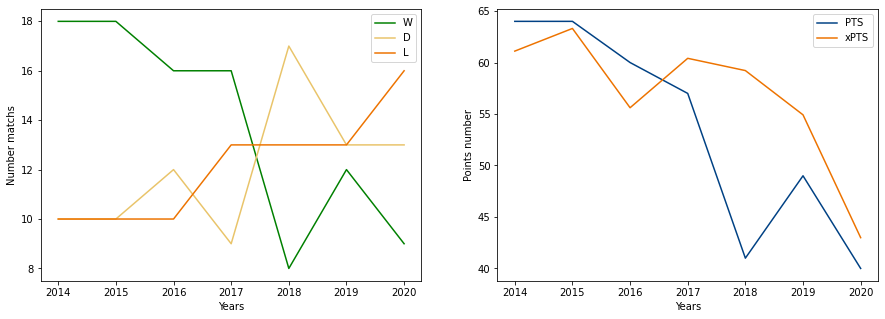

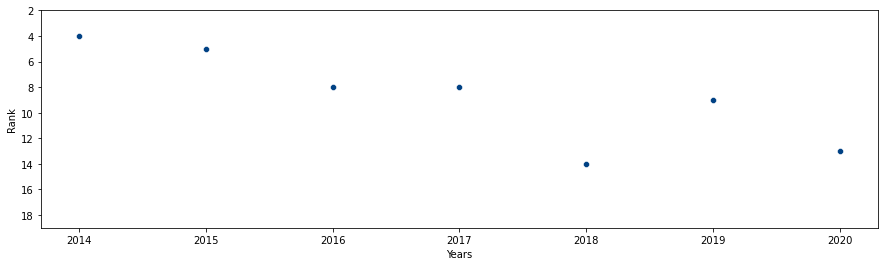

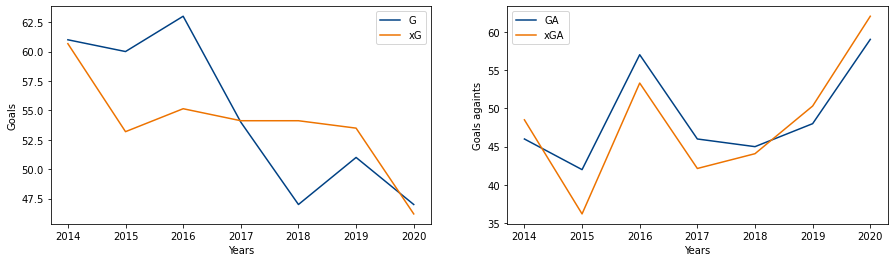

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=[15,5])
# plt.plot(list(ars['Years']), list(ars['L']), label='L')
plt.subplot(121)
sns.lineplot(x="Years",y='W',data=ars,color='green',label='W')
sns.lineplot(x="Years",y='D',data=ars,color='#e9c46a',label='D')
sns.lineplot(x="Years",y='L',data=ars,color='#ED7300',label='L')
plt.ylabel('Number matchs')
plt.subplot(122)
sns.lineplot(x="Years",y='PTS',data=ars,color='#004184',label='PTS')
sns.lineplot(x="Years",y='xPTS',data=ars,color='#ED7300',label='xPTS')
plt.ylabel('Points number')
plt.show()
plt.figure(figsize=[15,4])
sns.scatterplot(x="Years",y='Rank',data=ars,color='#004184')
plt.ylim(19,2)
# for index,row in zip(range(0,len(ars.index)),ars['Rank']):
#     print(row)
#     plt.text(index*0.1,,str(row), color='black', ha="center")
plt.show()
plt.figure(figsize=[15,4])
plt.subplot(121)
sns.lineplot(x="Years",y='G',data=ars,color='#004184',label='G')
sns.lineplot(x="Years",y='xG',data=ars,color='#ED7300',label='xG')
plt.ylabel('Goals')
plt.subplot(122)
sns.lineplot(x="Years",y='GA',data=ars,color='#004184',label='GA')
sns.lineplot(x="Years",y='xGA',data=ars,color='#ED7300',label='xGA')
plt.ylabel('Goals againts')
plt.show()

### Player

In [25]:
euro_ligue_corr = ligue_corr[ligue_corr['Rank'] < 7]

In [26]:
euro_ligue_corr['Team'].unique()

array(['Juventus', 'Roma', 'Lazio', 'Fiorentina', 'Napoli', 'Genoa',
       'Inter', 'Sassuolo', 'Atalanta', 'AC Milan'], dtype=object)

In [46]:
df_player

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup,year
0,1513,Mauro Icardi,36,2897,22,20.0405,6,4.6076,121,34,4,0,F S,Inter,18,16.2340,23.2430,4.9106,2014
1,1955,Luca Toni,38,3228,22,21.2048,2,2.9143,125,27,3,0,F S,Verona,18,16.6370,18.8106,3.1060,2014
2,3848,Carlos Tévez,32,2594,20,13.3721,7,5.0166,114,61,6,0,F M S,Juventus,18,10.3270,20.0076,8.9075,2014
3,1293,Gonzalo Higuaín,37,2786,18,21.0974,7,4.0822,113,49,5,0,F S,Napoli,15,15.7683,22.7116,4.9174,2014
4,2014,Jérémy Menez,33,2713,16,10.9369,4,4.3797,78,46,3,1,F M S,AC Milan,8,4.8466,13.7559,6.8897,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3922,9503,Kacper Urbanski,1,1,0,0.0000,0,0.0000,0,0,0,0,S,Bologna,0,0.0000,0.0000,0.0000,2020
3923,9518,Edoardo Bove,1,8,0,0.0000,0,0.0000,0,0,0,0,S,Roma,0,0.0000,0.0775,0.0775,2020
3924,9539,Antonio Raimondo,1,1,0,0.0000,0,0.0000,0,0,0,0,S,Bologna,0,0.0000,0.0000,0.0000,2020
3925,9550,Yayah Kallon,1,42,0,0.1221,0,0.0220,2,1,0,0,S,Genoa,0,0.1221,0.2757,0.1317,2020


In [47]:
df_ars_players_stat = []
for i in year:
    goals = sum(df_player[(df_player['team_title'] == 'Fiorentina')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['goals'])    
    expect_goals = sum(df_player[(df_player['team_title'] == 'Fiorentina')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['xG'])
    np = sum(df_player[(df_player['team_title'] == 'Fiorentina')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['npg'])    
    npG = sum(df_player[(df_player['team_title'] == 'Fiorentina')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['npxG'])
    red_card = sum(df_player[(df_player['team_title'] == 'Fiorentina')&(df_player['year'] == int(i))]['red_cards'])
    yellow_card = sum(df_player[(df_player['team_title'] == 'Fiorentina')&(df_player['year'] == int(i))]['yellow_cards'])
    df_ars_players_stat.append(pd.DataFrame({'year':[i],'goals':[goals],'expect_goals':[expect_goals],'goals without penalty':[np],'expect goals without penalty':[npG],'red card':[red_card],'yellow card':[yellow_card]}))
stat_ars = pd.concat(df_ars_players_stat)

In [48]:
import numpy as np

In [49]:
list_goal_pourcent = []
for i,e in zip(stat_ars['goals'],ars['G']):
    #print(e,i)
    list_goal_pourcent.append(np.around(((i/e)*100),decimals=3))

In [50]:
stat_ars['Pourcent goal'] = list_goal_pourcent

A faire :

    - pourcentage de goals des 3 meilleurs buteurs sur l'ensemble des buts
    - red/yellow card 
 

In [51]:
stat_ars

,year,goals,expect_goals,goals without penalty,expect goals without penalty,red card,yellow card,Pourcent goal
0,2014,22,16.2642,20,12.4577,3,81,36.066
0,2015,30,30.8631,22,24.0114,3,87,50.000
0,2016,36,28.1133,31,22.7842,6,90,57.143
0,2017,28,26.1983,26,23.9144,5,79,51.852
0,2018,20,26.3267,20,26.3267,5,86,42.553
0,2019,23,26.9830,14,18.6088,5,95,45.098
0,2020,29,24.5834,23,20.0156,4,84,61.702


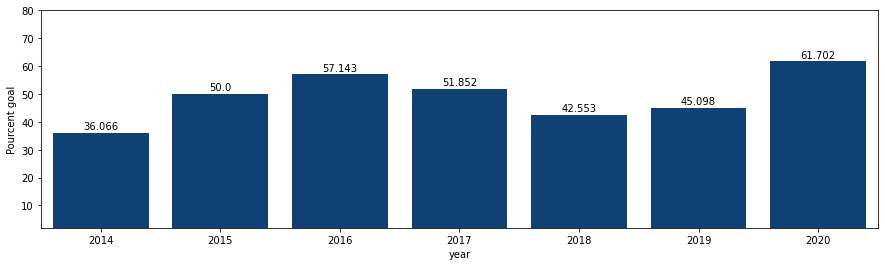

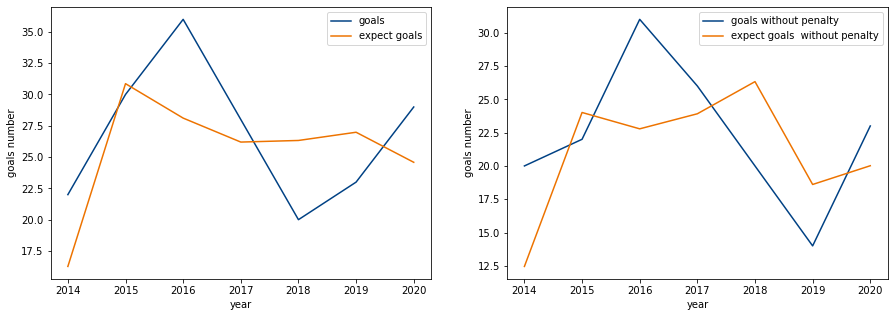

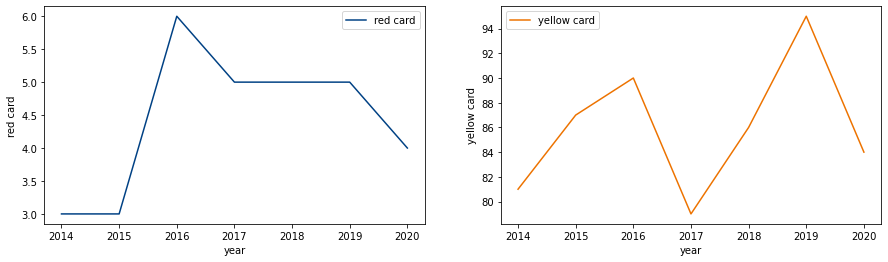

In [52]:
plt.figure(figsize=[15,4])
sns.barplot(x="year",y='Pourcent goal',data=stat_ars,color='#004184')
rects = stat_ars["year"]
labels = stat_ars['Pourcent goal']
for rect, label in zip(range(0,(len(rects))), labels):
    height = label
    plt.text(
        rect, height + 0.5, label, ha="center", va="bottom"
    )
plt.ylim(2,80)
plt.show()
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.lineplot(x="year",y='goals',data=stat_ars,color='#004184',label='goals')
sns.lineplot(x="year",y='expect_goals',data=stat_ars,color='#ED7300',label='expect goals')
plt.ylabel('goals number')
plt.subplot(122)
sns.lineplot(x="year",y='goals without penalty',data=stat_ars,color='#004184',label='goals without penalty')
sns.lineplot(x="year",y='expect goals without penalty',data=stat_ars,color='#ED7300',label='expect goals  without penalty')
plt.ylabel('goals number')
plt.show()
plt.figure(figsize=[15,4])
plt.subplot(121)
sns.lineplot(x="year",y='red card',data=stat_ars,color='#004184',label='red card')
plt.subplot(122)
sns.lineplot(x="year",y='yellow card',data=stat_ars,color='#ED7300',label='yellow card')
plt.show()

# Concurrents

In [53]:
ars

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef
3,4,Fiorentina,38,18,10,10,61,46,64,60.67,48.50,61.11,2014,1.017,0.958,1.049
24,5,Fiorentina,38,18,10,10,60,42,64,53.19,36.22,63.31,2015,1.132,1.167,1.016
47,8,Fiorentina,38,16,12,10,63,57,60,55.14,53.30,55.61,2016,1.145,1.075,1.091
67,8,Fiorentina,38,16,9,13,54,46,57,54.12,42.15,60.41,2017,1.000,1.095,0.950
93,14,Fiorentina,38,8,17,13,47,45,41,54.12,44.08,59.22,2018,0.870,1.023,0.695
108,9,Fiorentina,38,12,13,13,51,48,49,53.49,50.30,54.92,2019,0.962,0.960,0.907
132,13,Fiorentina,38,9,13,16,47,59,40,46.20,62.02,42.99,2020,1.022,0.952,0.952


In [54]:
euro_ligue_corr = ligue_corr[ligue_corr['Rank'] < 7]

In [55]:
# ligue_corr[ligue_corr['Years'] == 2019]

In [56]:
ars_point= ars.set_index('Years')[['PTS','Rank']].T

In [57]:
list(ars_point.values[0])

[64, 64, 60, 57, 41, 49, 40]

In [58]:
# euro_ligue_corr

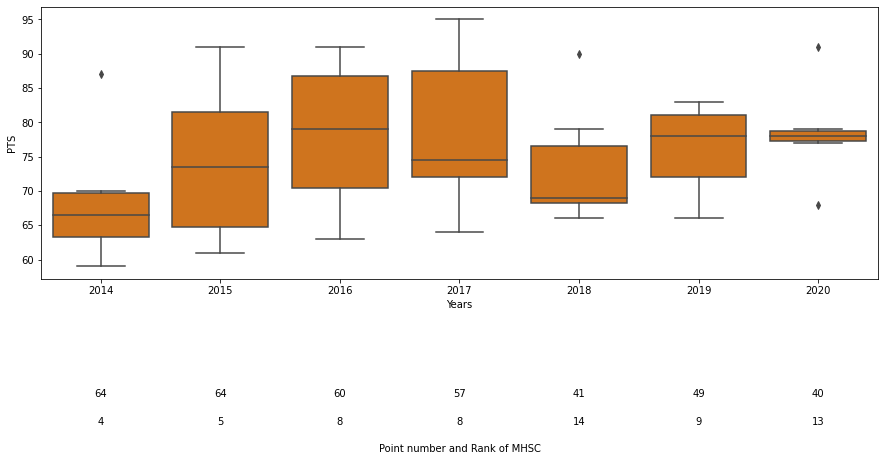

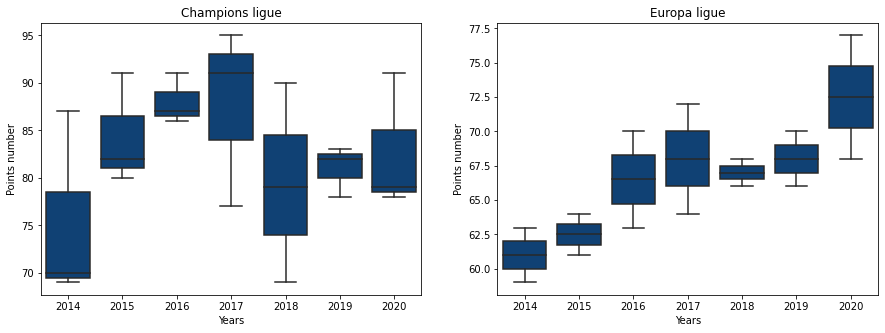

In [59]:
plt.figure(figsize=[15,5])
sns.boxplot(x='Years',y='PTS',data=euro_ligue_corr,color='#ED7300')  
rects = year
labels_point = list(ars_point.values[0])
labels_rank = list(ars_point.values[1])
plt.text(3,32,'Point number and Rank of MHSC',horizontalalignment='center')
for rect, label1,label2 in zip(range(0,(len(rects))), labels_point,labels_rank):
    height = label
    plt.text(rect, 40, label1,horizontalalignment='center')
    plt.text(rect, 36, label2,horizontalalignment='center')
plt.show()
# print()[].T)
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.boxplot(x="Years",y='PTS',data=euro_ligue_corr[euro_ligue_corr['Rank'] < 4],color='#004184')
plt.ylabel('Points number')
plt.title('Champions ligue')
plt.subplot(122)
sns.boxplot(x="Years",y='PTS',data=euro_ligue_corr[(euro_ligue_corr['Rank'] > 4)&(euro_ligue_corr['Rank'] < 8)],color='#004184')
plt.ylabel('Points number')
plt.title('Europa ligue')
plt.show()

# Expected points 

In [60]:
ars_expect_point = ars.set_index('Years')[['xPTS coef','Rank']].T

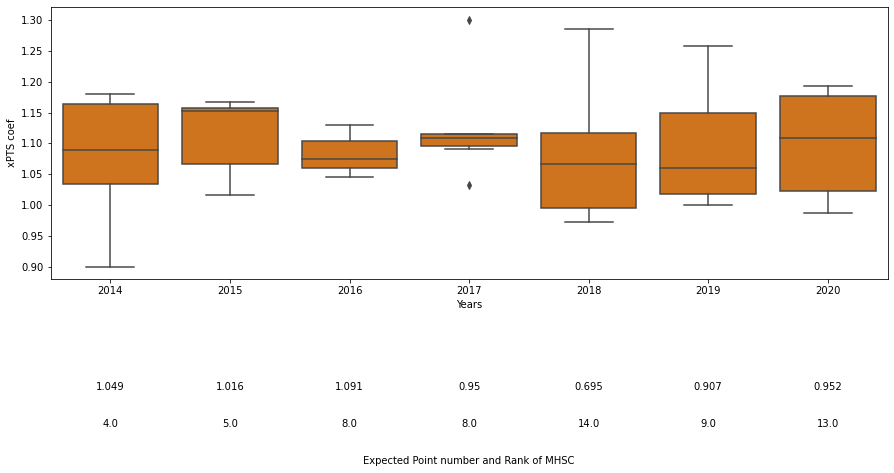

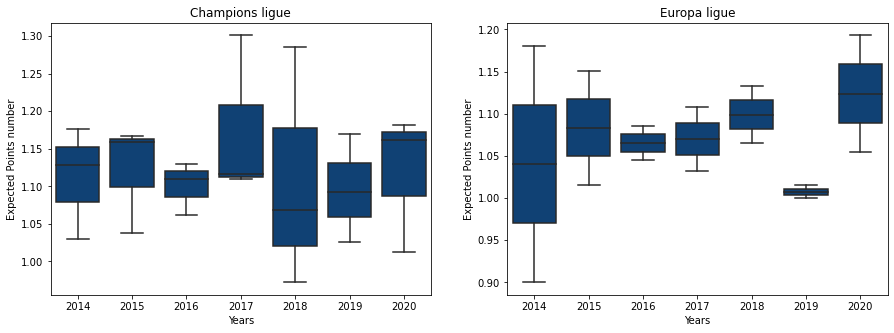

In [61]:
plt.figure(figsize=[15,5])
sns.boxplot(x='Years',y='xPTS coef',data=euro_ligue_corr,color='#ED7300')  
rects = year
labels_point = list(ars_expect_point.values[0])
labels_rank = list(ars_expect_point.values[1])
plt.text(3,0.58,'Expected Point number and Rank of MHSC',horizontalalignment='center')
for rect, label1,label2 in zip(range(0,(len(rects))), labels_point,labels_rank):
    height = label
    plt.text(rect, 0.7, label1,horizontalalignment='center')
    plt.text(rect, 0.64, label2,horizontalalignment='center')
plt.show()
# print()[].T)
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.boxplot(x="Years",y='xPTS coef',data=euro_ligue_corr[euro_ligue_corr['Rank'] < 4],color='#004184')
plt.ylabel('Expected Points number')
plt.title('Champions ligue')
plt.subplot(122)
sns.boxplot(x="Years",y='xPTS coef',data=euro_ligue_corr[(euro_ligue_corr['Rank'] > 4)&(euro_ligue_corr['Rank'] < 8)],color='#004184')
plt.ylabel('Expected Points number')
plt.title('Europa ligue')
plt.show()

# Valeurs marchandes

In [62]:
df_euro

,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions),Years,Crew
0,Gardien,"25,83",2.80,0.467,2014,juventus turin
1,Défense,"26,58",81.50,6.790,2014,juventus turin
2,Milieu de terrain,"25,30",170.40,17.040,2014,juventus turin
3,Attaquant,"26,29",74.30,10.610,2014,juventus turin
4,Total,"26,03",329.00,9.400,2014,juventus turin
...,...,...,...,...,...,...
1045,Gardien,"26,80",5.03,1.010,2020,spezia calcio
1046,Défense,"24,00",18.65,1.330,2020,spezia calcio
1047,Milieu de terrain,"24,17",30.00,2.500,2020,spezia calcio
1048,Attaquant,"25,25",18.00,2.250,2020,spezia calcio


In [63]:
# for e,a,u in zip(df_euro['Valeur marchande (millions)'],df_euro['Crew'],df_euro['Positions']):
#     if 'K' in e:
#         print(e,a,u)

In [64]:
df_euro.dropna(axis=0,inplace=True)

In [65]:
# df_value_1 = []
# df_value_2 = []
# for i,e in zip(df_euro['Valeur marchande (millions)'],df_euro['Valeur marchande moyenne (millions)']):
#     if ('K' in e)&('K' in i):
#         df_value_1.append(float(i.split(' ')[0])/1000)
#         df_value_2.append(float(e.split(' ')[0])/1000)
#     elif 'K' in e:
#         df_value_1.append(float(i.replace(',','.')))
#         df_value_2.append(float(e.split(' ')[0])/1000)
#     elif 'K' in i:
#         df_value_1.append(float(i.split(' ')[0])/1000)
#         df_value_2.append(float(e.replace(',','.')))
#     else:
#         df_value_1.append(i.replace(',','.'))
#         df_value_2.append(i.replace(',','.'))

In [66]:
# df_euro['Valeur marchande (millions)'] = df_value_1
# df_euro['Valeur marchande moyenne (millions)'] = df_value_2

In [67]:
df_euro['Âge'] = [i.replace(',','.') for i in df_euro['Âge']] 
# df_euro['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro['Valeur marchande (millions)']] 
# df_euro['Valeur marchande moyenne (millions)'] = [i.replace(',','.') for i in df_euro['Valeur marchande moyenne (millions)']] 
# df_euro['Valeur marchande moyenne (millions)'] = [i.split(' ')[0] for i in df_euro['Valeur marchande moyenne (millions)']] 
# df_euro['Valeur marchande (millions)'] = [i.split(' ')[0] for i in df_euro['Valeur marchande (millions)']] 

In [68]:
column = ['Âge', 'Valeur marchande (millions)',
       'Valeur marchande moyenne (millions)']
for i in column:
    df_euro[i] = df_euro[i].astype(float)

In [93]:
ars_max = value_max[value_max['Crew'] == 'ac-florenz']

In [94]:
total = df_euro[(df_euro['Crew'] == 'ac florenz')&(df_euro['Positions'] == 'Total')]

In [95]:
value_max['Crew'].unique()

array(['juventus-turin', 'as-rom', 'lazio-rom', 'ac-florenz',
       'ssc-neapel', 'genua-cfc', 'sampdoria-genua', 'inter-mailand',
       'fc-turin', 'ac-mailand', 'palermo-fc', 'us-sassuolo',
       'hellas-verona', 'chievo-verona', 'fc-empoli', 'udinese-calcio',
       'atalanta-bergamo', 'cagliari-calcio', 'parma-calcio-1913',
       'cesena-fc', 'fc-bologna', 'carpi-fc-1909', 'frosinone-calcio',
       'fc-crotone', 'delfino-pescara-1936', 'spal', 'benevento-calcio',
       'us-lecce', 'brescia-calcio', 'spezia-calcio'], dtype=object)

In [96]:
# print(df_euro['Crew'].unique())
# print(euro_ligue_corr['Team'].unique())

In [97]:
ars_max

,Position,Valeur maximum,Years,Crew
105,Gardien,7.5,2014,ac-florenz
106,Défense,32.0,2014,ac-florenz
107,Milieu,18.0,2014,ac-florenz
108,Attaquant,20.0,2014,ac-florenz
109,Total,32.0,2014,ac-florenz
110,Gardien,5.0,2015,ac-florenz
111,Défense,8.0,2015,ac-florenz
112,Milieu,14.0,2015,ac-florenz
113,Attaquant,16.0,2015,ac-florenz
114,Total,16.0,2015,ac-florenz


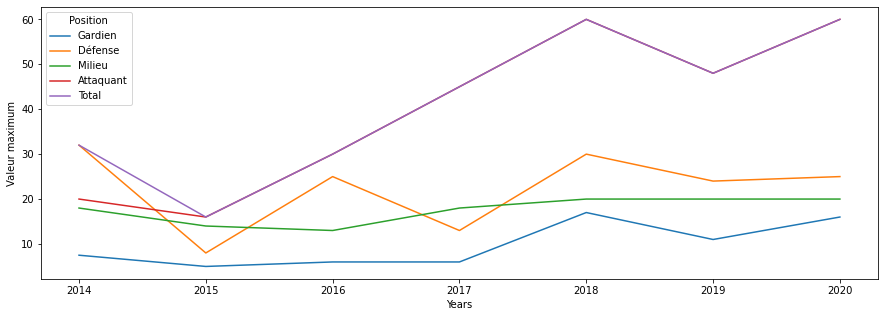

In [98]:
plt.figure(figsize=[15,5])
sns.lineplot(x='Years',y='Valeur maximum',hue='Position',data=ars_max)
plt.show()

In [99]:
# ligue_corr['Team'].unique()

In [100]:
# list(df_euro['Team'].unique()[10:])

In [101]:
print(ligue_corr['Team'].unique())
print(df_euro['Crew'].unique())

['Juventus' 'Roma' 'Lazio' 'Fiorentina' 'Napoli' 'Genoa' 'Sampdoria'
 'Inter' 'Torino' 'AC Milan' 'Palermo' 'Sassuolo' 'Verona' 'Chievo'
 'Empoli' 'Udinese' 'Atalanta' 'Cagliari' 'Parma' 'Cesena' 'Bologna'
 'Carpi' 'Frosinone' 'Crotone' 'Pescara' 'SPAL 2013' 'Benevento'
 'Parma Calcio 1913' 'Lecce' 'Brescia' 'Spezia']
['juventus turin' 'as rom' 'lazio rom' 'ac florenz' 'ssc neapel' 'genua c'
 'sampdoria genua' 'inter mailand' ' turin' 'ac mailand' 'palermo '
 'us sassuolo' 'hellas verona' 'chievo verona' ' empoli' 'udinese calcio'
 'atalanta bergamo' 'cagliari calcio' 'parma calcio 1913' 'cesena '
 ' bologna' 'carpi  1909' 'frosinone calcio' ' crotone'
 'delfino pescara 1936' 'spal' 'benevento calcio' 'us lecce'
 'brescia calcio' 'spezia calcio']


'ChelseaManchester City'

In [104]:
df_euro['Crew'] = [i.replace('juventus turin','Juventus') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('as rom','Roma') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('lazio rom','Lazio') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('ac florenz','Fiorentina') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('ssc neapel','Napoli') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('genua c','Genoa') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('sampdoria genua','Sampdoria') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('inter mailand','Inter') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' turin','Torino') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('ac mailand','AC Milan') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('palermo ','Palermo') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('us sassuolo','Sassuolo') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('hellas verona','Verona') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('chievo verona','Chievo') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' empoli','Empoli') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('udinese calcio','Udinese') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('atalanta bergamo','Atalanta') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('cagliari calcio','Cagliari') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('parma calcio 1913','Parma') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('cesena ','Cesena') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' bologna','Bologna') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('carpi  1909','Carpi') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('frosinone calcio','Frosinone') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' crotone','Crotone') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('delfino pescara 1936','Pescara') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('spal','SPAL') for i in df_euro['Crew']]
ligue_corr['Team'] = [i.replace('SPAL 2013','SPAL') for i in ligue_corr['Team']]
df_euro['Crew'] = [i.replace('benevento calcio','Benevento') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('us lecce','Lecce') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('brescia calcio','Brescia') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('spezia calcio','Spezia') for i in df_euro['Crew']]


df_euro.rename(columns={'Crew':'Team'},inplace=True)

In [110]:
ligue_corr['Team'] = [i.replace('Parma Calcio 1913','Parma') for i in ligue_corr['Team']]


In [111]:
df_lig_val = ligue_corr.merge(df_euro,how='inner',on=['Team','Years'])

In [112]:
df_lig_val[df_lig_val['Years'] == 2020]['Rank'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

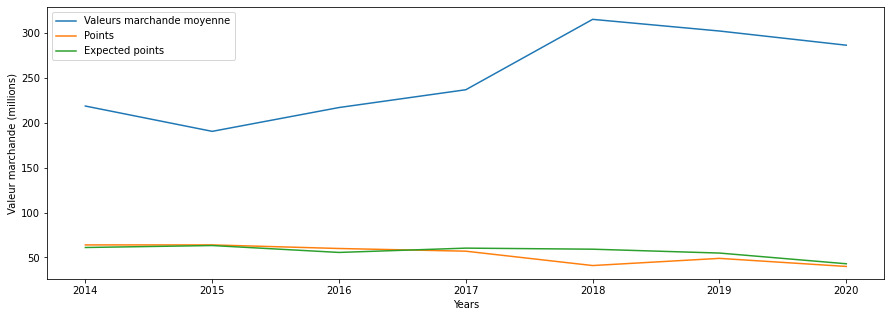

In [113]:
plt.figure(figsize=[15,5])
sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
sns.lineplot(x='Years',y='PTS',data=ars,label='Points')
sns.lineplot(x='Years',y='xPTS',data=ars,label='Expected points')
# rects = year
# labels_rank = list(ars['Rank'])
# plt.text(3,0.32,'Point number and Rank of MHSC',horizontalalignment='center')
# for rect, label in zip(range(0,len(rects)), labels_rank):
#     plt.text(rect, 0.36, label,horizontalalignment='center')
plt.show()

### Corrélation valeurs marchande / résultats 

In [114]:
df_lig_val

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
0,1,Juventus,38,26,9,3,72,24,87,59.08,29.13,74.79,2014,1.220,0.828,1.176,Gardien,25.83,2.80,0.467
1,1,Juventus,38,26,9,3,72,24,87,59.08,29.13,74.79,2014,1.220,0.828,1.176,Défense,26.58,81.50,6.790
2,1,Juventus,38,26,9,3,72,24,87,59.08,29.13,74.79,2014,1.220,0.828,1.176,Milieu de terrain,25.30,170.40,17.040
3,1,Juventus,38,26,9,3,72,24,87,59.08,29.13,74.79,2014,1.220,0.828,1.176,Attaquant,26.29,74.30,10.610
4,1,Juventus,38,26,9,3,72,24,87,59.08,29.13,74.79,2014,1.220,0.828,1.176,Total,26.03,329.00,9.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,20,Parma,38,3,11,24,39,83,20,42.98,66.69,37.49,2020,0.929,1.258,0.541,Gardien,22.60,4.40,0.880
696,20,Parma,38,3,11,24,39,83,20,42.98,66.69,37.49,2020,0.929,1.258,0.541,Défense,24.72,40.95,2.280
697,20,Parma,38,3,11,24,39,83,20,42.98,66.69,37.49,2020,0.929,1.258,0.541,Milieu de terrain,24.67,35.30,2.350
698,20,Parma,38,3,11,24,39,83,20,42.98,66.69,37.49,2020,0.929,1.258,0.541,Attaquant,23.27,48.05,3.200


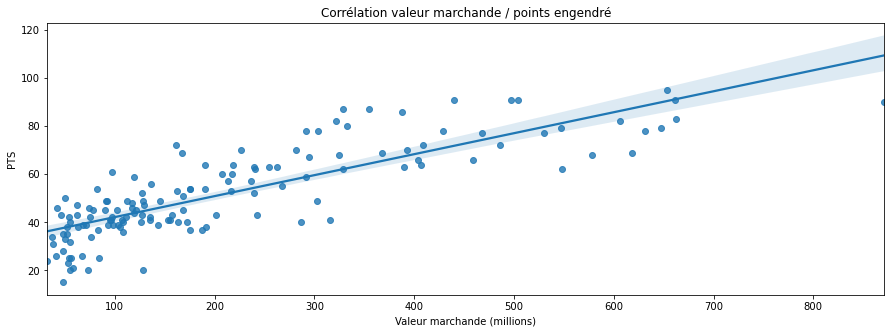

Covariance empirique :  2628.5011612244894
Coefficient de Pearson :  0.8240570468768952

Les valeurs suivent une distribution linéaire


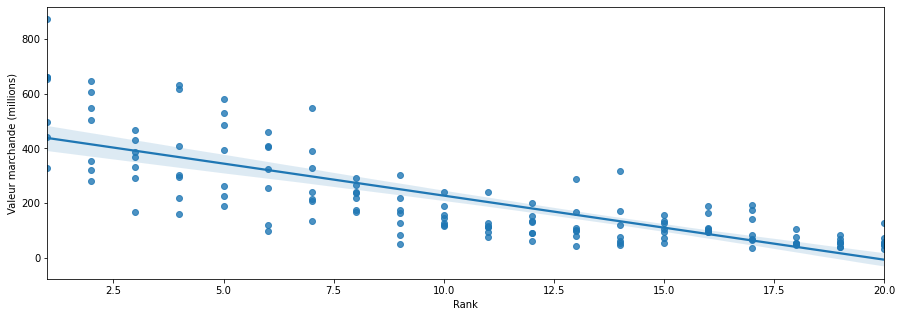

Covariance empirique :  -778.1078571428568
Coefficient de Pearson :  -0.7772334836392015

Les valeurs suivent une distribution linéaire


In [118]:
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='PTS',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
plt.title('Corrélation valeur marchande / points engendré')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Total']["PTS"])
plt.figure(figsize=[15,5])
sns.regplot(x='Rank',y='Valeur marchande (millions)',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']['Rank'],df_lig_val[df_lig_val['Positions'] == 'Total']['Valeur marchande (millions)'])


### Corrélation valeurs marchande / buts marqués - encaissés

In [119]:
df_lig_val[(df_lig_val['G'] > 50)&(df_lig_val['Positions'] == 'Attaquant')]

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
3,1,Juventus,38,26,9,3,72,24,87,59.08,29.13,74.79,2014,1.220,0.828,1.176,Attaquant,26.29,74.30,10.61
8,2,Roma,38,19,13,6,54,31,70,50.85,36.79,62.16,2014,1.080,0.861,1.129,Attaquant,23.91,89.83,8.17
13,3,Lazio,38,21,6,11,71,38,69,62.00,35.87,67.79,2014,1.145,1.086,1.030,Attaquant,22.67,34.70,3.86
18,4,Fiorentina,38,18,10,10,61,46,64,60.67,48.50,61.11,2014,1.017,0.958,1.049,Attaquant,25.00,70.73,5.89
23,5,Napoli,38,18,9,11,70,54,63,64.50,34.37,70.72,2014,1.094,1.588,0.900,Attaquant,24.78,129.30,14.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,7,Roma,38,18,9,11,68,55,63,72.11,50.33,65.20,2020,0.944,1.100,0.969,Attaquant,22.50,52.65,4.39
638,8,Sassuolo,38,17,11,10,64,56,62,61.61,54.82,57.31,2020,1.049,1.037,1.088,Attaquant,22.83,99.05,8.25
643,9,Sampdoria,38,15,7,16,52,54,52,46.70,58.63,44.07,2020,1.130,0.931,1.182,Attaquant,25.38,38.80,4.85
658,12,Bologna,38,10,11,17,51,65,41,57.53,67.59,49.36,2020,0.895,0.970,0.837,Attaquant,21.85,55.10,4.24


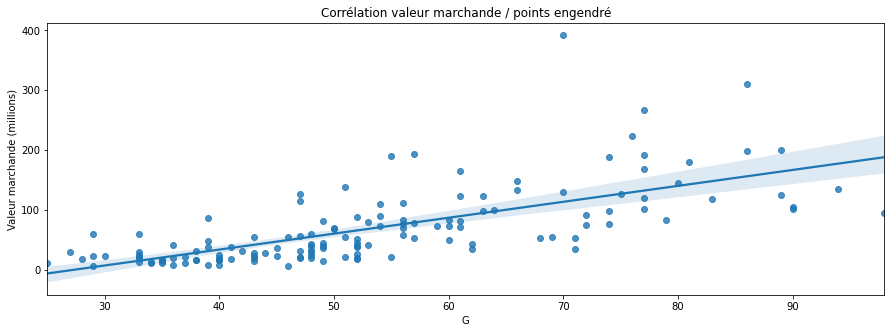

Covariance empirique :  712.5099
Coefficient de Pearson :  0.6870813757783871

Les valeurs suivent une distribution linéaire


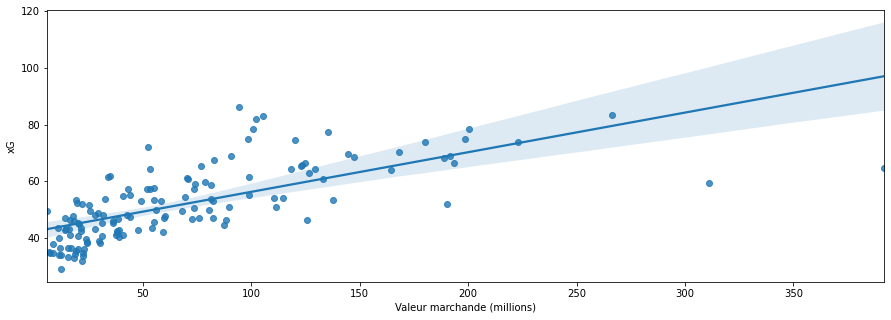

Covariance empirique :  561.4568484285717
Coefficient de Pearson :  0.6885110236378825

Les valeurs suivent une distribution linéaire


In [120]:
# buts marqués
plt.figure(figsize=[15,5])
sns.regplot(x='G',y='Valeur marchande (millions)',data=df_lig_val[df_lig_val['Positions'] == 'Attaquant'])
plt.title('Corrélation valeur marchande / points engendré')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Attaquant']["G"],df_lig_val[df_lig_val['Positions'] == 'Attaquant']["Valeur marchande (millions)"])
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='xG',data=df_lig_val[df_lig_val['Positions'] == 'Attaquant'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Attaquant']['Valeur marchande (millions)'],df_lig_val[df_lig_val['Positions'] == 'Attaquant']['xG'])


In [121]:
df_lig_val[df_lig_val['Positions'] == 'Gardien']

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
0,1,Juventus,38,26,9,3,72,24,87,59.08,29.13,74.79,2014,1.220,0.828,1.176,Gardien,25.83,2.80,0.467
5,2,Roma,38,19,13,6,54,31,70,50.85,36.79,62.16,2014,1.080,0.861,1.129,Gardien,28.40,3.40,0.680
10,3,Lazio,38,21,6,11,71,38,69,62.00,35.87,67.79,2014,1.145,1.086,1.030,Gardien,23.25,10.40,2.600
15,4,Fiorentina,38,18,10,10,61,46,64,60.67,48.50,61.11,2014,1.017,0.958,1.049,Gardien,26.00,11.93,1.990
20,5,Napoli,38,18,9,11,70,54,63,64.50,34.37,70.72,2014,1.094,1.588,0.900,Gardien,28.20,6.70,1.340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,16,Cagliari,38,9,10,19,43,59,37,45.60,65.26,41.13,2020,0.956,0.908,0.902,Gardien,25.25,22.30,5.580
680,17,Torino,38,7,16,15,50,69,37,49.60,64.22,44.68,2020,1.020,1.078,0.841,Gardien,28.40,3.63,0.725
685,18,Benevento,38,7,12,19,40,75,33,38.65,70.48,32.75,2020,1.053,1.071,1.031,Gardien,28.00,3.80,0.950
690,19,Crotone,38,6,5,27,45,92,23,39.64,77.48,29.87,2020,1.154,1.195,0.793,Gardien,25.50,0.85,0.213


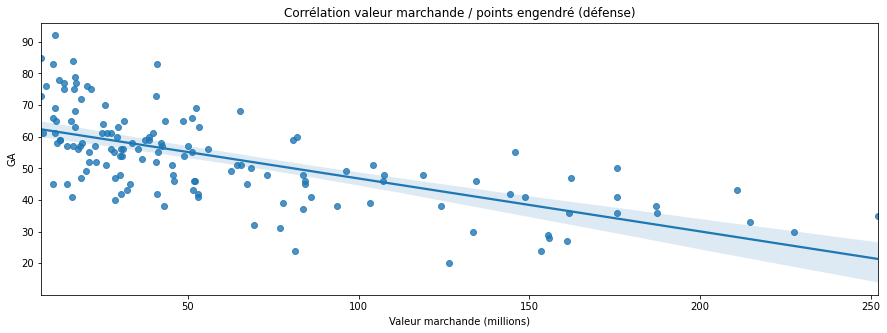

Covariance empirique :  -493.5244142857144
Coefficient de Pearson :  -0.6478908616197365

Les valeurs suivent une distribution linéaire


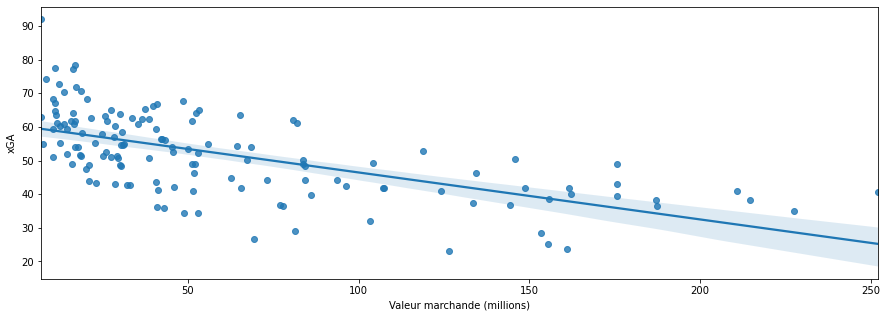

Covariance empirique :  -412.1400018979593
Coefficient de Pearson :  -0.6210352415194439

Les valeurs suivent une distribution linéaire


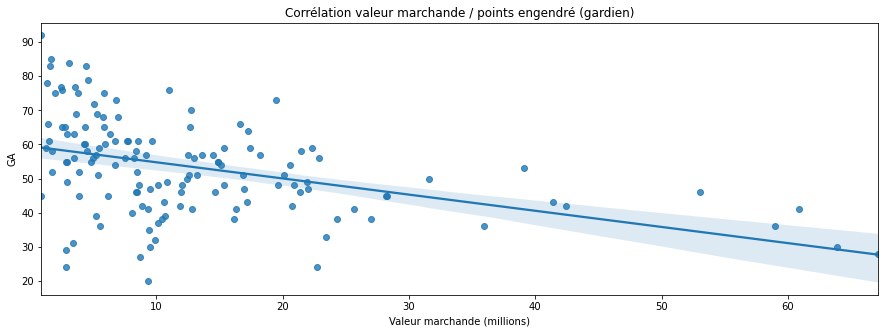

Covariance empirique :  -74.7943857142857
Coefficient de Pearson :  -0.42466791355107875

Les valeurs suivent une distribution linéaire


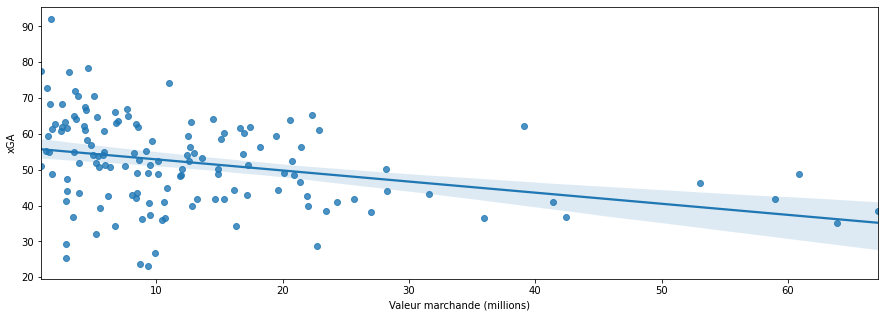

Covariance empirique :  -48.85648837244897
Coefficient de Pearson :  -0.3184057934386175

Les valeurs suivent une distribution linéaire


In [122]:
# buts encaissé
#défense
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='GA',data=df_lig_val[df_lig_val['Positions'] == 'Défense'])
plt.title('Corrélation valeur marchande / points engendré (défense)')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Défense']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Défense']["GA"])
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='xGA',data=df_lig_val[df_lig_val['Positions'] == 'Défense'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Défense']['xGA'],df_lig_val[df_lig_val['Positions'] == 'Défense']['Valeur marchande (millions)'])
#gardien
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='GA',data=df_lig_val[df_lig_val['Positions'] == 'Gardien'])
plt.title('Corrélation valeur marchande / points engendré (gardien)')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Gardien']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Gardien']["GA"])
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='xGA',data=df_lig_val[df_lig_val['Positions'] == 'Gardien'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Gardien']['xGA'],df_lig_val[df_lig_val['Positions'] == 'Gardien']['Valeur marchande (millions)'])


In [123]:
df_lig_val['Years'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [125]:
df_lig_val['win_rate'] = np.around(df_lig_val['W']/df_lig_val['M'],decimals=3)

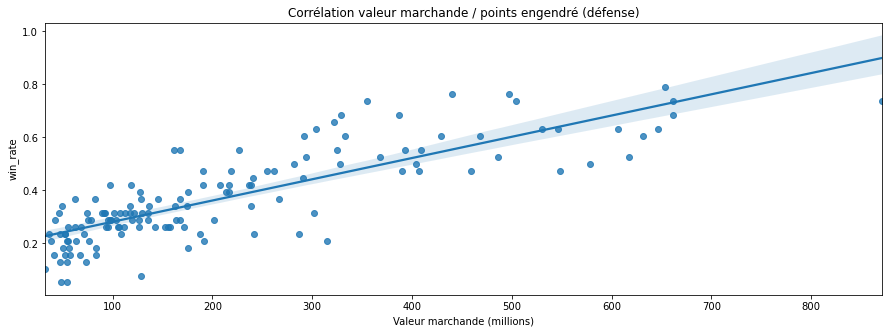

Covariance empirique :  24.157023763265304
Coefficient de Pearson :  0.8214378849516014

Les valeurs suivent une distribution linéaire


In [126]:
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='win_rate',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
plt.title('Corrélation valeur marchande / points engendré (défense)')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Total']["win_rate"])

In [283]:
df_value_pond_av = []
for i in list(df_lig_val['Team'].unique()):
    for a in list(df_lig_val['Years'].unique()):
        try:
            gardien = 0.5*int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Gardien')]['Valeur marchande (millions)'])
            defense = int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Défense')]['Valeur marchande (millions)'])
            milieu = 0.5*int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Milieu de terrain')]['Valeur marchande (millions)'])
            attaque = int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Attaquant')]['Valeur marchande (millions)'])
            total = int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['Valeur marchande (millions)'])
            rank = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['Rank']
            pts = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['PTS']
            buts = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['G']
            buts_enc = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['GA']
            xbuts = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['xG']
            xbuts_enc = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['xGA']
            win_rate = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['win_rate']

            df_value_pond_av.append(pd.DataFrame({'Rank':rank,'Team':i,'Years':a,'PTS':pts,'win_rate':win_rate,'G':buts,'GA':buts_enc,'xG':xbuts,'xGA':xbuts_enc,'Value totale':total,'Value attaque': np.around((attaque+milieu*0.25)/1.25,decimals=3),'Value défense': np.around((gardien*0.5+defense*1.25+milieu*0.25)/2,decimals=3)}))
        except TypeError:
            continue

In [284]:
value_pond_av = pd.concat(df_value_pond_av)

In [285]:
value_pond_av.to_csv('pond_value_serieA.csv', index=False)

### Corrélation valeurs marchande pondérée / buts marqués - encaissés

In [40]:
value_pond = pd.read_csv('pond_value_serieA.csv',sep=',')

In [4]:
value_pond[value_pond['Years'] == 2014]

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense
0,1,Juventus,2014,87,0.684,72,24,59.08,29.13,329,76.2,61.500
7,2,Roma,2014,70,0.500,54,31,50.85,36.79,281,82.3,55.438
14,3,Lazio,2014,69,0.553,71,38,62.00,35.87,167,35.1,33.062
21,4,Fiorentina,2014,64,0.474,61,46,60.67,48.50,218,61.1,57.062
28,5,Napoli,2014,63,0.474,70,54,64.50,34.37,262,110.9,35.562
35,6,Genoa,2014,59,0.421,62,47,57.32,60.37,118,37.4,21.375
42,7,Sampdoria,2014,56,0.342,48,42,47.59,48.37,136,51.3,22.188
49,8,Inter,2014,55,0.368,59,48,57.17,44.32,267,68.4,54.250
56,9,Torino,2014,54,0.368,48,45,51.78,42.69,82,21.8,22.500
63,10,AC Milan,2014,52,0.342,56,50,47.07,53.99,239,73.1,48.688


In [288]:
df_player

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup,year
0,1513,Mauro Icardi,36,2897,22,20.0405,6,4.6076,121,34,4,0,F S,Inter,18,16.2340,23.2430,4.9106,2014
1,1955,Luca Toni,38,3228,22,21.2048,2,2.9143,125,27,3,0,F S,Verona,18,16.6370,18.8106,3.1060,2014
2,3848,Carlos Tévez,32,2594,20,13.3721,7,5.0166,114,61,6,0,F M S,Juventus,18,10.3270,20.0076,8.9075,2014
3,1293,Gonzalo Higuaín,37,2786,18,21.0974,7,4.0822,113,49,5,0,F S,Napoli,15,15.7683,22.7116,4.9174,2014
4,2014,Jérémy Menez,33,2713,16,10.9369,4,4.3797,78,46,3,1,F M S,AC Milan,8,4.8466,13.7559,6.8897,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3922,9503,Kacper Urbanski,1,1,0,0.0000,0,0.0000,0,0,0,0,S,Bologna,0,0.0000,0.0000,0.0000,2020
3923,9518,Edoardo Bove,1,8,0,0.0000,0,0.0000,0,0,0,0,S,Roma,0,0.0000,0.0775,0.0775,2020
3924,9539,Antonio Raimondo,1,1,0,0.0000,0,0.0000,0,0,0,0,S,Bologna,0,0.0000,0.0000,0.0000,2020
3925,9550,Yayah Kallon,1,42,0,0.1221,0,0.0220,2,1,0,0,S,Genoa,0,0.1221,0.2757,0.1317,2020


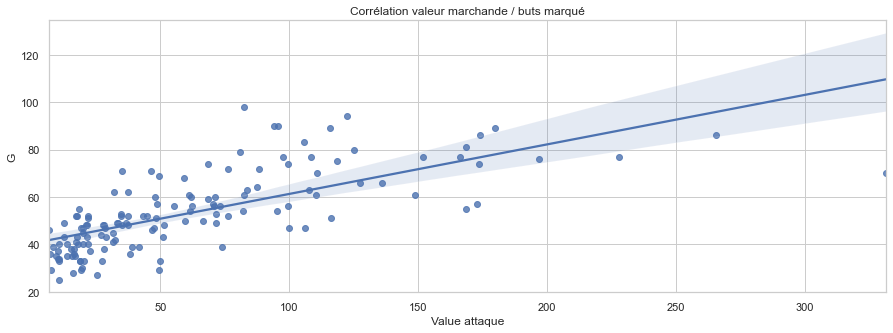

Covariance empirique :  640.2291428571432
Coefficient de Pearson :  0.7073221869930151

Les valeurs suivent une distribution linéaire


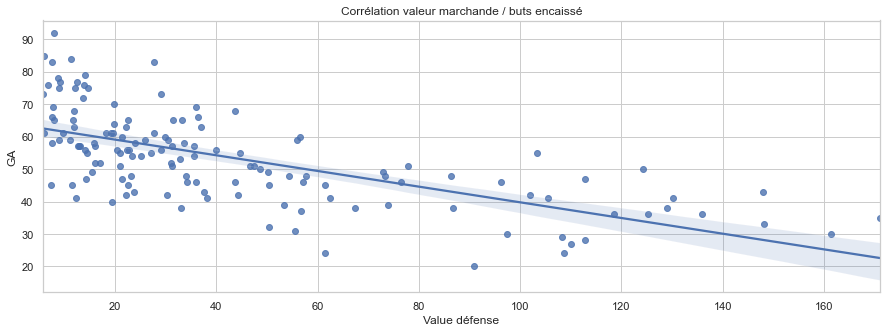

Covariance empirique :  -351.4689314285716
Coefficient de Pearson :  -0.6572944969823653

Les valeurs suivent une distribution linéaire


In [289]:
# buts marqué
#défense
plt.figure(figsize=[15,5])
sns.regplot(x="Value attaque",y='G',data=value_pond)
plt.title('Corrélation valeur marchande / buts marqué')
plt.show()
corré_quant(value_pond["Value attaque"],value_pond["G"])
plt.figure(figsize=[15,5])
sns.regplot(x='Value défense',y='GA',data=value_pond)
plt.title('Corrélation valeur marchande / buts encaissé')
plt.show()
corré_quant(value_pond['Value défense'],value_pond['GA'])

In [290]:
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

page = ['https://sofifa.com/players?type=all&lg%5B0%5D=31&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=140052&set=true&offset=',
        'https://sofifa.com/players?type=all&lg%5B0%5D=31&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=150059&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=31&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=160058&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=31&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=170099&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=31&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=180084&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=31&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=190075&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=31&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=200061&set=true&offset=']

In [291]:
b = 0
list_error_name = [' L. Messi',' L. Messi',' L. Messi',' Cristiano Ronaldo',' L. Messi',' L. Messi',' L. Messi']
list_page_glob = []
x = 2014
for i in page:
    y = 0
    list_page = []
    while str(requests.get("{}{}".format(str(i),str(y)), headers=headers)) == '<Response [200]>':
        print(x,y)
        #print("{}{}".format(str(i),str(y)),"{}{}".format(str(i),str(y))=='https://sofifa.com/players')
        pageTree = requests.get("{}{}".format(str(i),str(y)), headers=headers)
        soup = BeautifulSoup(pageTree.content, 'html.parser')
        name = str(soup.body.find('div',{'class':'column col-auto'}).table.tbody.find_all('tr')[0].find('td',{"class":'col-name'}).find('div',{'class':'bp3-text-overflow-ellipsis'}).text)
        #print("{}{}".format(str(i),str(y)),name,b)
        if str(name) == list_error_name[b]:
            b = b + 1
            break
        else:
            list_name = []
            list_name.append(name)
            print(list_name)
            list_page.append("{}{}".format(str(i),str(y)))
            y = y +60
    x = x +1
    list_page_glob.append(list_page)

2014 0
[' A. Vidal']
2014 60
[' S. Lulić']
2014 120


KeyboardInterrupt: 

In [ ]:


df_fifa = []
x = 2014

for k in list_page_glob:
    #print(k)
    for e in k:
        pageTree = requests.get(e, headers=headers)
        soup = BeautifulSoup(pageTree.content, 'html.parser')
        
        value = soup.body.find('div',{'class':'column col-auto'}).table.tbody.find_all('tr')
        #print(value)
        for i in value:
            
            name = i.find('td',{"class":'col-name'}).find('div',{'class':'bp3-text-overflow-ellipsis'}).text
            age = i.find('td',{'class':'col col-ae'}).text
            club = i.find_all('td',{'class':'col-name'})[1].find('div',{'class':'bp3-text-overflow-ellipsis'}).a.text
#             print(i)
            poste = i.find('td',{'class':'col col-bp'}).text
            poid = i.find('td',{'class':'col col-hi'}).text
            accele = int(i.find('td',{'class':'col col-sp'}).span.text)
            speed = int(i.find('td',{'class':'col col-ac'}).span.text)
            offensif = int(i.find('td',{'class':'col col-ta'}).span.text)
            tech = int(i.find('td',{'class':'col col-ts'}).span.text)
            mouv = int(i.find('td',{'class':'col col-to'}).span.text)
            def_gene = int(i.find('td',{'class':'col col-td'}).span.text)
            gardien = int(i.find('td',{'class':'col col-tg'}).span.text)
            df_fifa.append(pd.DataFrame({'name':[name],'poste':[poste],'Team':[club],'taille':[poid],'accélération':[accele],'speed':[speed],'offensif':[offensif],'technique':[tech],'mouvement':[mouv],'defense general':[def_gene],'gardien general':[gardien],'Years':x}))

        #print(df_fifa)
    x = x + 1
#     print(x)
fifa = pd.concat(df_fifa)

In [ ]:
# for i in fifa[fifa['Years'] == 2020]['poid']:
#     print(i.split('"')[0])
#     dist = Distance(=i.split('"')[0].split("'")[0],inch=i.split('"')[0].split("'")[1])
#     print(dist.m)

In [ ]:
fifa

In [141]:
fifa.to_csv('fifa_glob_serieA.csv',index=False)

In [41]:
fifa = pd.read_csv('fifa_glob_serieA.csv',sep=',')

In [42]:
list_taille = []
for i in fifa['taille']:
    list_taille.append(np.around(int(i.split('"')[0].split("'")[0])*30.48 + int(i.split('"')[0].split("'")[1])*2.54,decimals=0))

In [43]:
fifa['taille'] = list_taille

In [44]:
moy_playeurs = fifa.groupby(['poste','Years']).mean().reset_index()

In [45]:
moy_playeurs

,poste,Years,taille,accélération,speed,offensif,technique,mouvement,defense general,gardien general
0,AD,2014,175.363636,78.545455,80.424242,318.393939,344.181818,377.969697,101.878788,41.454545
1,AD,2015,175.675676,81.432432,82.486486,319.891892,337.405405,387.891892,98.189189,39.891892
2,AD,2016,176.407407,81.777778,82.814815,329.851852,346.222222,391.444444,100.074074,48.444444
3,AD,2017,177.363636,80.000000,82.181818,322.727273,319.181818,386.363636,78.181818,51.181818
4,AD,2018,178.200000,79.400000,80.400000,318.200000,312.600000,381.000000,98.200000,48.800000
...,...,...,...,...,...,...,...,...,...,...
100,MOC,2016,179.609756,70.317073,71.731707,334.463415,366.292683,353.731707,117.756098,47.804878
101,MOC,2017,179.189873,73.164557,75.443038,325.316456,361.151899,366.367089,120.658228,48.139241
102,MOC,2018,178.104478,74.805970,76.701493,329.656716,365.895522,377.373134,118.447761,47.149254
103,MOC,2019,179.526316,73.105263,74.719298,333.350877,368.614035,371.403509,149.070175,49.666667


In [46]:
fifa['Team'].unique()

array(['Juventus', 'AS Rome', 'Naples', 'Fiorentina', 'Inter',
       'Lazio Rome', 'Milan', 'Parma', 'Torino', 'Udinese', 'Atalanta',
       'Cagliari', 'Chievo Vérone', 'Genoa', 'Hellas Vérone', 'Sampdoria',
       'Livourne', 'Bologne', 'Sassuolo', 'Catane', 'Palerme', 'Empoli',
       'Cesena', 'Carpi', 'Frosinone', 'Pescara', 'Crotone', 'SPAL',
       'Benevento', 'Brescia', 'Lecce'], dtype=object)

In [47]:
from itertools import zip_longest
years = fifa['Years'].unique()
df_off_coef = []
for i in years:
    poste = ['BU','MOC', 'AG', 'AD','AT','MC']
    for e in poste:
        value = fifa[(fifa['Years'] == i)&(fifa['poste'] == e)]
        for q,k,a,j,l,g in zip_longest(value['Team'],value['accélération'],value['speed'],value['offensif'],value['technique'],value['mouvement']):
            #print(q,k,a,i,l,g)
            value_moy = moy_playeurs[(moy_playeurs['Years'] == i)&(moy_playeurs['poste'] == e)]
#             print(value_moy['accélération'],value_moy['speed'],value_moy['offensif'],value_moy['technique'],value_moy['mouvement'])
            accel = np.around(k/int(value_moy['accélération']),decimals=3)
            speedo = np.around(a/int(value_moy['speed']),decimals=3)
            offense = np.around(j/int(value_moy['offensif']),decimals=3)
            tech = np.around(l/int(value_moy['technique']),decimals=3)
            mouv = np.around(g/int(value_moy['mouvement']),decimals=3)
            df_off_coef.append(pd.DataFrame({'Team':[q],'poste':[e],'accélération':[accel], 'speed':[speedo], 'offensif':[offense],
       'technique':[tech], 'mouvement':[mouv], 'Years':[i]}))
off_coef = pd.concat(df_off_coef)

In [48]:
from itertools import zip_longest
years = fifa['Years'].unique()
df_off_coef = []
for i in years:
    poste = ['DC', 'MDC', 'DLG','DG', 'DLD', 'DD']
    for e in poste:
        value = fifa[(fifa['Years'] == i)&(fifa['poste'] == e)]
        for q,k,a,j,l,g in zip_longest(value['Team'],value['taille'],value['accélération'],value['speed'],value['defense general'],value['gardien general']):
            #print(q,k,a,i,l,g)
            value_moy = moy_playeurs[(moy_playeurs['Years'] == i)&(moy_playeurs['poste'] == e)]
#             print(value_moy['accélération'],value_moy['speed'],value_moy['offensif'],value_moy['technique'],value_moy['mouvement'])
            accel = np.around(a/int(value_moy['accélération']),decimals=3)
            speedo = np.around(j/int(value_moy['speed']),decimals=3)
            tail = np.around(k/float(value_moy['taille']),decimals=3)
            def_gene = np.around(l/int(value_moy['defense general']),decimals=3)
            df_off_coef.append(pd.DataFrame({'Team':[q],'poste':[e], 'taille':[tail],'accélération':[accel], 'speed':[speedo],
       'defense generale':[def_gene], 'Years':[i]}))
def_coef = pd.concat(df_off_coef)

In [49]:
from itertools import zip_longest
years = fifa['Years'].unique()
df_off_coef = []
for i in years:
    value = fifa[(fifa['Years'] == i)&(fifa['poste'] == 'G')]
    for q,k,a in zip_longest(value['Team'],value['taille'],value['gardien general']):
        value_moy = moy_playeurs[(moy_playeurs['Years'] == i)&(moy_playeurs['poste'] == 'G')]
#             print(value_moy['accélération'],value_moy['speed'],value_moy['offensif'],value_moy['technique'],value_moy['mouvement'])
        tail = np.around(k/float(value_moy['taille']),decimals=3)
        gard = np.around(a/int(value_moy['gardien general']),decimals=3)
        df_off_coef.append(pd.DataFrame({'Team':[q],'poste':'G', 'taille':[tail],'gardien generale':[gard], 'Years':[i]}))
gard_coef = pd.concat(df_off_coef)

In [50]:
gard_coef['coef'] = np.around((gard_coef['taille']+gard_coef['gardien generale']*1.5)/2.5,decimals=5)

In [51]:
def_coef['coef'] = np.around((def_coef['taille']+def_coef['accélération']+def_coef['speed']+def_coef['defense generale']*1.5)/4.5,decimals=5)

In [52]:
off_coef['coef'] = np.around((off_coef['offensif']*1.5+off_coef['accélération']+off_coef['speed']+off_coef['mouvement']+off_coef['technique'])/5.5,decimals=5)

In [53]:
def_coef = def_coef[['Team','poste','Years','coef']]

In [54]:
gard_coef = gard_coef[['Team','poste','Years','coef']]

In [55]:
off_coef = off_coef[['Team','poste','Years','coef']]

In [56]:
list_def_coef = []
def_coef[def_coef['poste'] == 'DC']['coef'] = def_coef[def_coef['poste'] == 'DC']['coef']*1.5
list_def_coef.append(def_coef[def_coef['poste'] == 'DC'])
list_def_coef.append(def_coef[def_coef['poste'] != 'DC'])
list_def_coef.append(gard_coef)
def_coef_glob = pd.concat(list_def_coef)

<ipython-input-56-03152599a842>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_coef[def_coef['poste'] == 'DC']['coef'] = def_coef[def_coef['poste'] == 'DC']['coef']*1.5


In [57]:
list_off_coef = []
off_coef[off_coef['poste'] == 'MC']['coef'] = off_coef[off_coef['poste'] == 'MC']['coef']*0.75
list_off_coef.append(off_coef[off_coef['poste'] == 'MC'])
list_off_coef.append(off_coef[off_coef['poste'] != 'MC'])
off_coef_glob = pd.concat(list_off_coef)

<ipython-input-57-f028df8da51d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_coef[off_coef['poste'] == 'MC']['coef'] = off_coef[off_coef['poste'] == 'MC']['coef']*0.75


In [58]:
off_coef_glob = off_coef_glob.groupby(['Team','Years']).mean().reset_index().sort_values(by='coef',ascending=False)

In [59]:
def_coef_glob = def_coef_glob.groupby(['Team','Years']).mean().reset_index().sort_values(by='coef',ascending=False)

In [60]:
df_coef = def_coef_glob.merge(off_coef_glob,how='inner',on=['Team','Years'])
df_coef.rename(columns={'coef_x':'coef défense','coef_y':'coef attaque'},inplace=True)

In [61]:
df_coef['Team'].unique()

array(['Juventus', 'Naples', 'Lazio Rome', 'Milan', 'Inter', 'AS Rome',
       'Fiorentina', 'Sampdoria', 'Torino', 'Udinese', 'Atalanta',
       'Palerme', 'Hellas Vérone', 'Parma', 'Brescia', 'Sassuolo',
       'Cagliari', 'Catane', 'Genoa', 'Empoli', 'Livourne',
       'Chievo Vérone', 'Bologne', 'Carpi', 'Lecce', 'Benevento',
       'Frosinone', 'SPAL', 'Crotone', 'Cesena', 'Pescara'], dtype=object)

In [62]:
value_pond['Team'].unique()

array(['Juventus', 'Roma', 'Lazio', 'Fiorentina', 'Napoli', 'Genoa',
       'Sampdoria', 'Inter', 'Torino', 'AC Milan', 'Palermo', 'Sassuolo',
       'Verona', 'Chievo', 'Empoli', 'Udinese', 'Atalanta', 'Cagliari',
       'Parma', 'Cesena', 'Bologna', 'Carpi', 'Frosinone', 'Crotone',
       'Pescara', 'SPAL', 'Benevento', 'Lecce', 'Brescia', 'Spezia'],
      dtype=object)

In [63]:
value_pond['Team'] = [i.replace('Roma','AS Rome') for i in value_pond['Team']] 
value_pond['Team'] = [i.replace('Napoli','Naples') for i in value_pond['Team']]
value_pond['Team'] = [i.replace('Palermo','Palerme') for i in value_pond['Team']]
value_pond['Team'] = [i.replace('Bologna','Bologne') for i in value_pond['Team']]
value_pond['Team'] = [i.replace('Verona','Hellas verone') for i in value_pond['Team']]
df_coef['Team'] = [i.replace('Hellas Vérone','Hellas verone') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Chievo Vérone','Chievo') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Milan','AC Milan') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Lazio Rome','Lazio') for i in df_coef['Team']] 

In [64]:
for i,h in zip(df_coef['Team'].unique(),value_pond['Team'].unique()):
#     print(i,h)
    if (i not in df_coef['Team'].unique())|(i not in value_pond['Team'].unique()):
        print(i,'i')
    elif (h not in value_pond['Team'].unique())|(h not in df_coef['Team'].unique()):
        print(h,'k')

Catane i
Livourne i
Spezia k


In [65]:
all_value = value_pond.merge(df_coef,how='inner',on=['Team','Years'])

In [66]:
all_value.to_csv('merge_value_serieA.csv',index=False)

In [67]:
all_value = pd.read_csv('merge_value_serieA.csv',sep=',')

In [70]:
list_euro = []
list_euro_detail = []
for i in all_value['Rank']:
    if i < 7:
        list_euro.append('Européen')
        if i < 5: 
            list_euro_detail.append('CL')
        else:
            list_euro_detail.append('EL')
    else:
        list_euro.append('Non-Européen')
        list_euro_detail.append('NE')
all_value['is_euro'] = list_euro
all_value['is_euro_detail'] = list_euro_detail

In [71]:
#méthode de calcul et d'affichage des cercles de corrélation et de l'ACP

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, pca, axis_ranks, labels=None, alpha=1):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    
    fig_1 = plt.figure(figsize=(8,7))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.savefig('Eboulis.png')
    plt.show(block=False)

In [72]:
all_value.columns

Index(['Rank', 'Team', 'Years', 'PTS', 'win_rate', 'G', 'GA', 'xG', 'xGA',
       'Value totale', 'Value attaque', 'Value défense', 'coef défense',
       'coef attaque', 'is_euro', 'is_euro_detail'],
      dtype='object')

In [73]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from sklearn import decomposition
from sklearn import preprocessing

data = all_value[['PTS', 'G', 'GA', 'Value totale',
       'Value attaque', 'Value défense', 'coef défense', 'coef attaque','win_rate']]
X = data.values

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

pca = decomposition.PCA(n_components = 4)
pca.fit(X_scaled)

PCA(n_components=4)

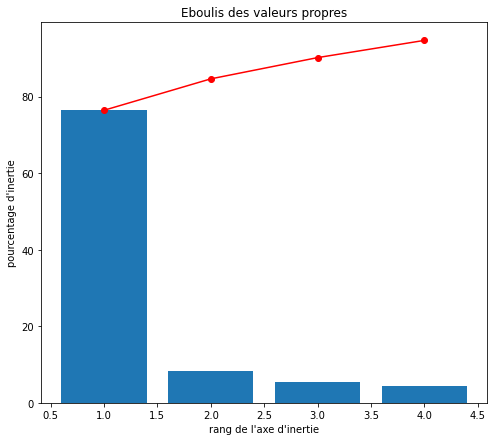

In [74]:
display_scree_plot(pca)

In [75]:
data

,PTS,G,GA,Value totale,Value attaque,Value défense,coef défense,coef attaque,win_rate
0,87,72,24,329,76.2,61.500,1.058296,1.065078,0.684
1,91,75,20,440,118.5,90.938,1.079119,1.064882,0.763
2,91,77,27,497,166.3,110.062,1.049728,1.031951,0.763
3,95,86,24,653,265.4,108.750,1.055966,1.102454,0.789
4,90,70,30,871,331.5,161.438,1.077475,1.106839,0.737
...,...,...,...,...,...,...,...,...,...
114,47,52,65,129,44.8,22.500,0.974943,1.020516,0.316
115,41,51,65,152,48.4,33.250,0.979301,1.017993,0.263
116,35,40,66,47,14.0,7.625,0.948241,0.919617,0.237
117,42,44,56,97,27.0,14.000,0.955840,0.990175,0.289


v1 : PTS
v2 : Buts marqués
v3 : Buts encaissés
v4 : Value totale
v5 : Value attaque
v6 : Value défense
v7 : coef défense
v8 : coef attaque
v9 : win rate


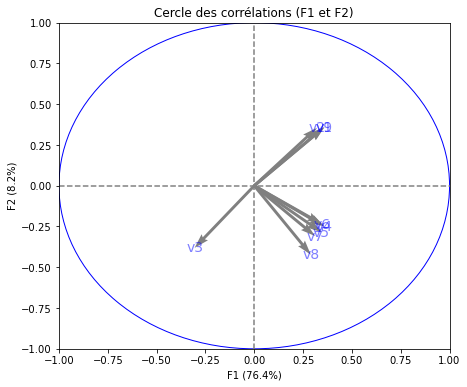

v3 est anti-corrélés aux variables PTS et coef attaque
v4,v5 et v6 ne sont corrélés à aucuns axes
v2,v7, v8 et v1 semblent être corrélés cependant les coefficients de corrélation sont plutôt faibles et traduisent une perte d'information
     
F1 : Capacité à faire avoir de bonnes performances / bon classement
     
F2 : incapacité à défendre
     


In [76]:
#ACP
features = data.columns
pcs = pca.components_
var = ['v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11']

print('v1 : PTS')
print('v2 : Buts marqués')
print('v3 : Buts encaissés')
print('v4 : Value totale')
print('v5 : Value attaque')
print('v6 : Value défense')
print('v7 : coef défense')
print('v8 : coef attaque')
print('v9 : win rate')

#display_circles(pcs, 4, pca, [(0,1),(2,3),(4,5)],labels = np.array(features))
display_circles(pcs, 4, pca, [(0,1)],labels = np.array(var))

X_projected = pca.transform(X_scaled)
#display_factorial_planes(X_projected_2, 4, pca2, [(0,1),(2,3)], alpha = 0.2)

print('v3 est anti-corrélés aux variables PTS et coef attaque')
print('v4,v5 et v6 ne sont corrélés à aucuns axes')
print("v2,v7, v8 et v1 semblent être corrélés cependant les coefficients de corrélation sont plutôt faibles et traduisent une perte d'information")
print(' '*5)
print('F1 : Capacité à faire avoir de bonnes performances / bon classement')
print(' '*5)
print('F2 : incapacité à défendre')
print(' '*5)


plt.show()

In [77]:
f1 = []
f2 = []
for i in X_projected:
    f1.append(i[0])
    f2.append(i[1])
    
all_value['F1'] = f1
all_value['F2'] = f2

### La qualité de représentation des individus

In [78]:
data_compo = pd.DataFrame(X_projected,index=data.index,columns=["F"+str(i+1) for i in range(4)])
data_compo = data_compo.drop(['F3','F4'],axis=1)
data_compo

,F1,F2
0,3.447896,1.121785
1,4.818276,0.800369
2,4.710369,0.853949
3,6.609037,-0.282154
4,7.510802,-2.258001
...,...,...
114,-1.709011,-0.155209
115,-1.773605,-0.545450
116,-3.911036,0.894079
117,-2.479483,0.508567


In [79]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = data_compo.values
#instanciation
sc = StandardScaler()
#transformation
Z = sc.fit_transform(X)

In [80]:
data_compo['is_euro'] = all_value['is_euro']
data_compo['is_euro_detail'] = all_value['is_euro_detail']

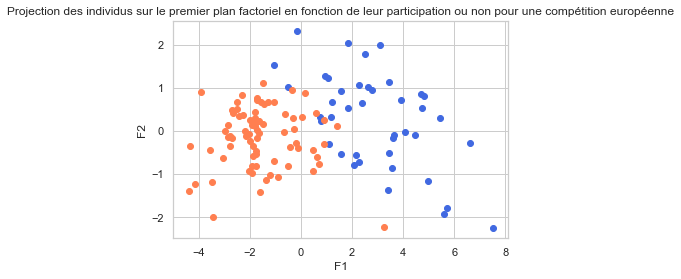

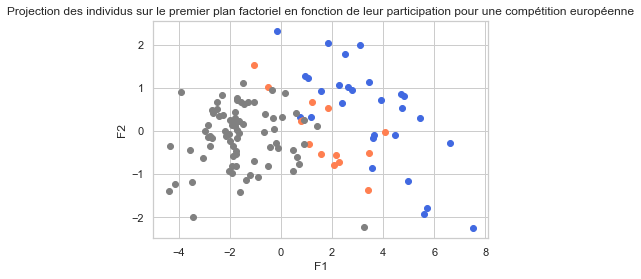

In [81]:
figsize = [15,7]
sns.set(style="whitegrid")
plt.scatter(data_compo[data_compo['is_euro'] == 'Européen']['F1'],data_compo[data_compo['is_euro'] == 'Européen']['F2'],c = 'royalblue')
plt.scatter(data_compo[data_compo['is_euro'] == 'Non-Européen']['F1'],data_compo[data_compo['is_euro'] == 'Non-Européen']['F2'],c = 'coral')
plt.title('Projection des individus sur le premier plan factoriel en fonction de leur participation ou non pour une compétition européenne')
plt.xlabel('F1')
plt.ylabel('F2')
plt.savefig('project1.png')
plt.show()
figsize = [15,7]
sns.set(style="whitegrid")
plt.scatter(data_compo[data_compo['is_euro_detail'] == 'CL']['F1'],data_compo[data_compo['is_euro_detail'] == 'CL']['F2'],c = 'royalblue')
plt.scatter(data_compo[data_compo['is_euro_detail'] == 'EL']['F1'],data_compo[data_compo['is_euro_detail'] == 'EL']['F2'],c = 'coral')
plt.scatter(data_compo[data_compo['is_euro_detail'] == 'NE']['F1'],data_compo[data_compo['is_euro_detail'] == 'NE']['F2'],c = 'grey')
plt.title('Projection des individus sur le premier plan factoriel en fonction de leur participation pour une compétition européenne')
plt.xlabel('F1')
plt.ylabel('F2')
plt.savefig('project1.png')
plt.show()

In [82]:
acp = PCA(svd_solver='full')
coord = acp.fit_transform(Z)

p = data_compo[['F1','F2']].shape[1]
di = np.sum(Z**2,axis=1)
contribu = pd.DataFrame({'d_i':di})
cos2 = coord**2
for j in range(p):
    cos2[:,j] = cos2[:,j]/di
data_cos = pd.DataFrame({'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]})

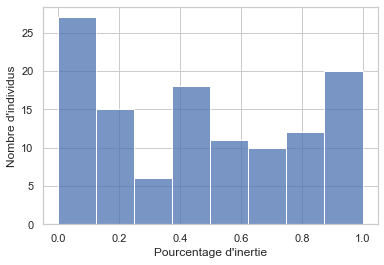

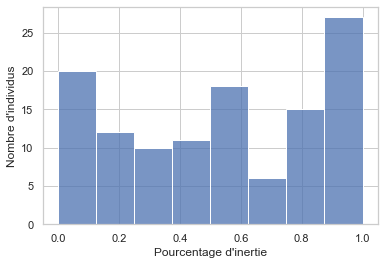

In [83]:
sns.histplot(x='COS2_1',data=data_cos)
plt.ylabel('Nombre d\'individus')
plt.xlabel('Pourcentage d\'inertie')
plt.show()
sns.histplot(x='COS2_2',data=data_cos)
plt.ylabel('Nombre d\'individus')
plt.xlabel('Pourcentage d\'inertie')
plt.show()

In [84]:
all_value[all_value['F1'] > 4]

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
1,1,Juventus,2015,91,0.763,75,20,62.99,23.00,440,118.5,90.938,1.079119,1.064882,Européen,CL,4.818276,0.800369
2,1,Juventus,2016,91,0.763,77,27,68.74,23.60,497,166.3,110.062,1.049728,1.031951,Européen,CL,4.710369,0.853949
3,1,Juventus,2017,95,0.789,86,24,59.23,28.58,653,265.4,108.750,1.055966,1.102454,Européen,CL,6.609037,-0.282154
4,1,Juventus,2018,90,0.737,70,30,64.53,35.03,871,331.5,161.438,1.077475,1.106839,Européen,CL,7.510802,-2.258001
5,1,Juventus,2019,83,0.684,76,43,73.77,41.00,661,197.0,148.000,1.077436,1.112051,Européen,CL,5.717768,-1.782999
6,4,Juventus,2020,78,0.605,77,38,83.53,38.33,631,227.9,129.062,1.083623,1.109677,Européen,CL,5.593440,-1.914531
31,2,Naples,2017,91,0.737,77,29,70.45,25.27,504,152.1,108.188,1.062510,1.045197,Européen,CL,4.748402,0.532142
32,2,Naples,2018,79,0.632,74,36,68.24,36.50,646,173.8,135.875,1.047454,1.101364,Européen,CL,4.987783,-1.166435
34,5,Naples,2020,77,0.632,86,41,74.98,41.88,530,174.1,105.438,1.055165,1.028091,Européen,EL,4.074039,-0.021985
54,2,Inter,2019,82,0.632,81,36,73.95,39.36,606,168.4,125.250,1.038843,1.044648,Européen,CL,4.456899,-0.089599


In [85]:
all_value[all_value['F2'] < -1]

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
4,1,Juventus,2018,90,0.737,70,30,64.53,35.03,871,331.5,161.438,1.077475,1.106839,Européen,CL,7.510802,-2.258001
5,1,Juventus,2019,83,0.684,76,43,73.77,41.00,661,197.0,148.000,1.077436,1.112051,Européen,CL,5.717768,-1.782999
6,4,Juventus,2020,78,0.605,77,38,83.53,38.33,631,227.9,129.062,1.083623,1.109677,Européen,CL,5.593440,-1.914531
27,13,Fiorentina,2020,40,0.237,47,59,46.20,62.02,286,106.2,56.000,1.011072,0.981915,Non-Européen,NE,-0.894442,-1.068691
32,2,Naples,2018,79,0.632,74,36,68.24,36.50,646,173.8,135.875,1.047454,1.101364,Européen,CL,4.987783,-1.166435
33,7,Naples,2019,62,0.474,61,50,63.88,43.17,548,148.8,124.250,1.051030,1.097413,Non-Européen,NE,3.252189,-2.221016
47,15,Sampdoria,2019,42,0.316,48,65,48.92,56.21,135,28.2,31.500,1.033373,1.030135,Non-Européen,NE,-1.221546,-1.026037
61,16,Torino,2019,40,0.289,46,68,43.49,63.49,163,46.8,43.625,1.030634,1.003683,Non-Européen,NE,-1.383120,-1.146834
62,17,Torino,2020,37,0.184,50,69,49.60,64.22,175,59.5,36.062,1.030414,1.003837,Non-Européen,NE,-1.582837,-1.413197
67,5,AC Milan,2018,68,0.500,55,36,52.16,41.70,578,168.7,118.438,1.031173,1.071937,Européen,EL,3.392527,-1.363328


C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


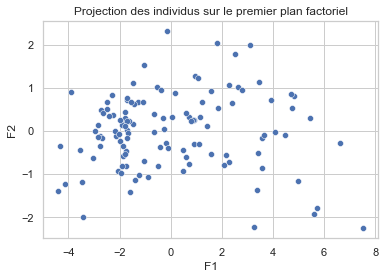

In [86]:
figsize = [15,7]
sns.set(style="whitegrid")
sns.scatterplot(all_value['F1'],all_value['F2'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection des individus sur le premier plan factoriel')
plt.xlabel('F1')
plt.ylabel('F2')
plt.savefig('project1.png')
plt.show()

### Corrélation entre F1 et le classement du club correspondant ? 

C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


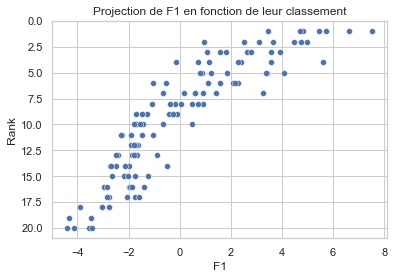

Covariance empirique :  -12.63442274092129
Coefficient de Pearson :  -0.8914674819610555

Les valeurs suivent une distribution linéaire


In [87]:
figsize = [15,7]
sns.set(style="whitegrid")
sns.scatterplot(all_value['F1'],all_value['Rank'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F1 en fonction de leur classement')
plt.xlabel('F1')
plt.ylabel('Rank')
plt.savefig('project1.png')
plt.ylim(21,0)
plt.show()
corré_quant(all_value['F1'],all_value['Rank'])

C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


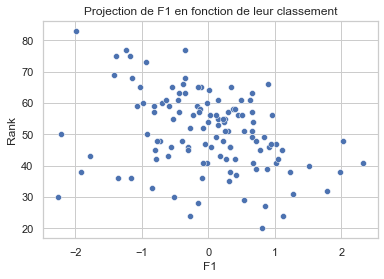

Covariance empirique :  -1.5921195382433238
Coefficient de Pearson :  -0.34276259231599954

Les valeurs suivent une distribution linéaire


In [88]:
figsize = [15,7]
sns.set(style="whitegrid")
sns.scatterplot(all_value['F2'],all_value['GA'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F1 en fonction de leur classement')
plt.xlabel('F1')
plt.ylabel('Rank')
plt.savefig('project1.png')
#plt.ylim(21,0)
plt.show()
corré_quant(all_value['F2'],all_value['Rank'])

In [89]:
all_value = all_value[(all_value['GA'] > 40)|(all_value['F2'] < 1)]

C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Covariance empirique :  -12.559883425561397
Coefficient de Pearson :  -0.8979563521051367

Les valeurs suivent une distribution linéaire
Covariance empirique :  -2.301360178329655
Coefficient de Pearson :  -0.23890448492220298

Les valeurs suivent une distribution linéaire


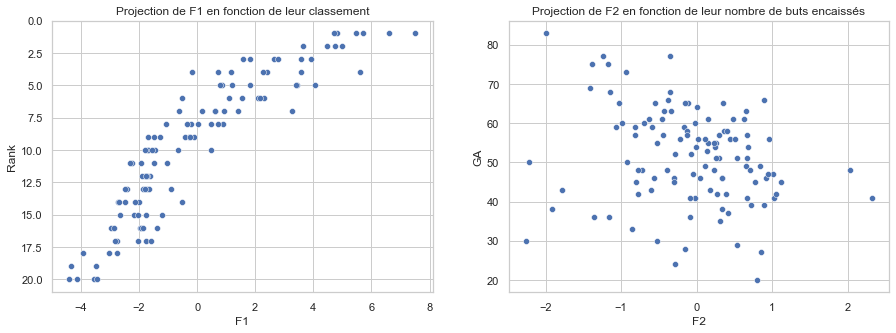

In [90]:
sns.set(style="whitegrid")
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.scatterplot(all_value['F1'],all_value['Rank'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F1 en fonction de leur classement')
plt.xlabel('F1')
plt.ylabel('Rank')

plt.ylim(21,0)
corré_quant(all_value['F1'],all_value['Rank'])
corré_quant(all_value['F2'],all_value['GA'])
plt.subplot(122)
sns.scatterplot(all_value['F2'],all_value['GA'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F2 en fonction de leur nombre de buts encaissés')
plt.xlabel('F2')
plt.ylabel('GA')
#plt.ylim(21,0)
plt.show()

In [91]:
all_value[all_value['is_euro'] == 'Européen']

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
1,1,Juventus,2015,91,0.763,75,20,62.99,23.00,440,118.5,90.938,1.079119,1.064882,Européen,CL,4.818276,0.800369
2,1,Juventus,2016,91,0.763,77,27,68.74,23.60,497,166.3,110.062,1.049728,1.031951,Européen,CL,4.710369,0.853949
3,1,Juventus,2017,95,0.789,86,24,59.23,28.58,653,265.4,108.750,1.055966,1.102454,Européen,CL,6.609037,-0.282154
4,1,Juventus,2018,90,0.737,70,30,64.53,35.03,871,331.5,161.438,1.077475,1.106839,Européen,CL,7.510802,-2.258001
5,1,Juventus,2019,83,0.684,76,43,73.77,41.00,661,197.0,148.000,1.077436,1.112051,Européen,CL,5.717768,-1.782999
6,4,Juventus,2020,78,0.605,77,38,83.53,38.33,631,227.9,129.062,1.083623,1.109677,Européen,CL,5.593440,-1.914531
8,3,AS Rome,2015,80,0.605,83,41,64.43,39.79,332,105.9,62.438,1.047412,1.015887,Européen,CL,2.640327,1.017933
10,3,AS Rome,2017,77,0.605,61,28,65.63,38.46,468,110.6,112.875,1.047622,1.062546,Européen,CL,3.585091,-0.158001
11,6,AS Rome,2018,66,0.474,66,48,68.39,52.79,459,136.0,86.250,1.043375,1.029981,Européen,EL,2.290882,-0.723434
12,5,AS Rome,2019,70,0.553,77,51,78.32,49.15,392,97.5,77.938,1.030610,0.994264,Européen,EL,1.833338,0.538914


Covariance empirique :  446.2266507006126
Coefficient de Pearson :  0.9488916797330038

Les valeurs suivent une distribution linéaire


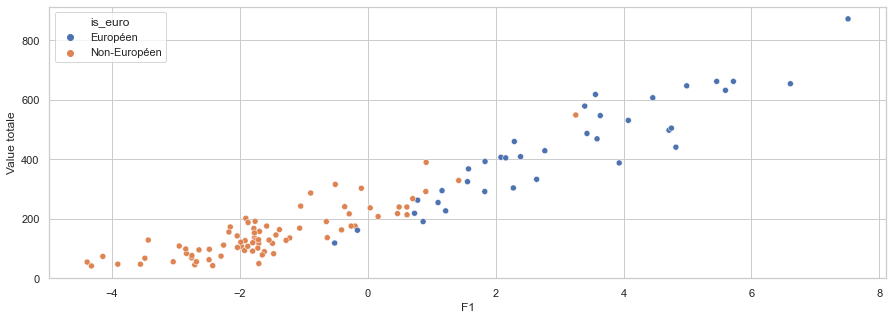

Covariance empirique :  -23.263010452461053
Coefficient de Pearson :  -0.8641731608021963

Les valeurs suivent une distribution linéaire


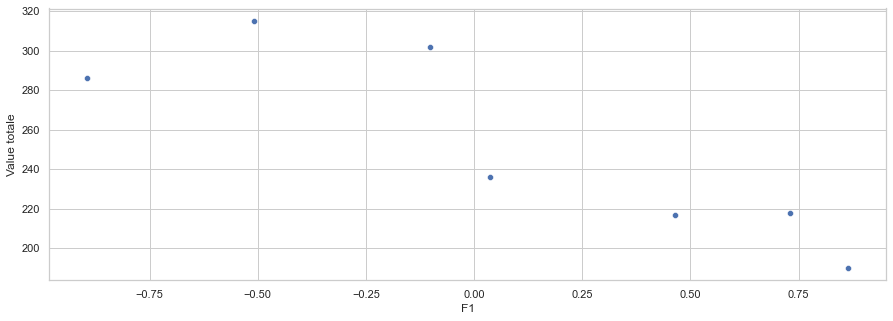

In [92]:
plt.figure(figsize=[15,5])
sns.scatterplot(x='F1',y='Value totale',hue='is_euro',data=all_value)
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(all_value['F1'],all_value['Value totale'])
plt.show()
plt.figure(figsize=[15,5])
sns.scatterplot(x='F1',y='Value totale',data=all_value[all_value['Team'] == 'Fiorentina'])
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(all_value[all_value['Team'] == 'Fiorentina']['F1'],all_value[all_value['Team'] == 'Fiorentina']['Value totale'])
plt.show()

In [93]:
all_value.head()

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
1,1,Juventus,2015,91,0.763,75,20,62.99,23.00,440,118.5,90.938,1.079119,1.064882,Européen,CL,4.818276,0.800369
2,1,Juventus,2016,91,0.763,77,27,68.74,23.60,497,166.3,110.062,1.049728,1.031951,Européen,CL,4.710369,0.853949
3,1,Juventus,2017,95,0.789,86,24,59.23,28.58,653,265.4,108.750,1.055966,1.102454,Européen,CL,6.609037,-0.282154
4,1,Juventus,2018,90,0.737,70,30,64.53,35.03,871,331.5,161.438,1.077475,1.106839,Européen,CL,7.510802,-2.258001
5,1,Juventus,2019,83,0.684,76,43,73.77,41.00,661,197.0,148.000,1.077436,1.112051,Européen,CL,5.717768,-1.782999


In [94]:
var_F2 = []
for i,a in zip(all_value['Value défense'],all_value['coef défense']):
    var_F2.append((a ** 3))
    print(i,'|',a,'|',(a ** 3))

90.938 | 1.0791191666666664 | 1.2566323011268392
110.062 | 1.0497276470588237 | 1.1567244262816496
108.75 | 1.0559658823529414 | 1.1774694822381453
161.438 | 1.0774746666666668 | 1.2508959999745308
148.0 | 1.0774357142857145 | 1.2507603393853217
129.062 | 1.0836233333333332 | 1.2724333520530922
62.438 | 1.047411875 | 1.1490858591579263
112.875 | 1.0476225 | 1.1497792107058535
86.25 | 1.043375 | 1.1358507771933593
77.938 | 1.03061 | 1.094669597015981
103.375 | 0.9963276470588238 | 0.9890233501788466
31.062 | 1.0395653333333337 | 1.1234541829954239
46.625 | 1.0235006666666668 | 1.0721718229808652
72.938 | 1.0360353846153847 | 1.1120485943899427
43.688 | 1.0576807142857143 | 1.183215244732842
44.188 | 1.046542 | 1.1462252906066523
44.688 | 1.0504864285714286 | 1.1592346079452738
57.062 | 1.0151226666666668 | 1.0460575436202997
30.25 | 1.0360233333333333 | 1.1120097884121458
35.625 | 1.0192308333333333 | 1.0588090868940725
34.188 | 1.0079486666666666 | 1.0240360461124405
61.438 | 0.9932325

Covariance empirique :  446.2266507006126
Coefficient de Pearson :  0.9488916797330038

Les valeurs suivent une distribution linéaire


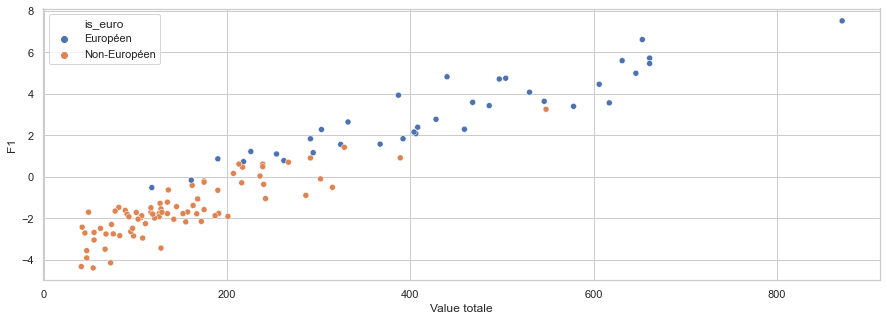

Covariance empirique :  -0.5808965654688298
Coefficient de Pearson :  -0.5983170645191427

Les valeurs suivent une distribution linéaire


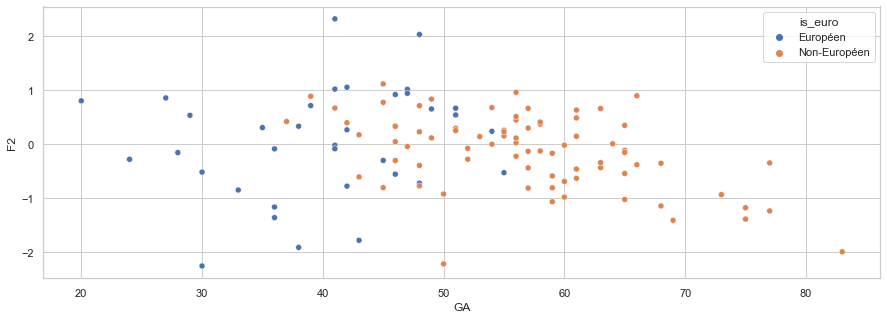

In [95]:
plt.figure(figsize=[15,5])
sns.scatterplot(x='Value totale',y='F1',hue='is_euro',data=all_value)
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(all_value['Value totale'],all_value['F1'])
plt.show()
plt.figure(figsize=[15,5])
sns.scatterplot(x='GA',y='F2',hue='is_euro',data=all_value)
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(var_F2,all_value['xGA'])
plt.show()

In [97]:
# Déterminer la fonction de la trend
x = all_value['Value totale']
y_F1= all_value['F1']
y_F2= all_value['F2']
z_F1 = np.polyfit(x,y_F1,1)
z_F2 = np.polyfit(x,y_F2,1)
print ("{0}x + {1}".format(*z_F1))
print ("{0}x + {1}".format(*z_F2))
y_list_F1 = []
y_list_F2 = []
for i in x:
    y_list_F1.append(0.014043285470786433*i + -3.4708104763730665)
    y_list_F2.append(-0.0011272856465777215*i + 0.19256428393287006)

0.014043285470786433x + -3.4708104763730665
-0.0011272856465777215x + 0.19256428393287006


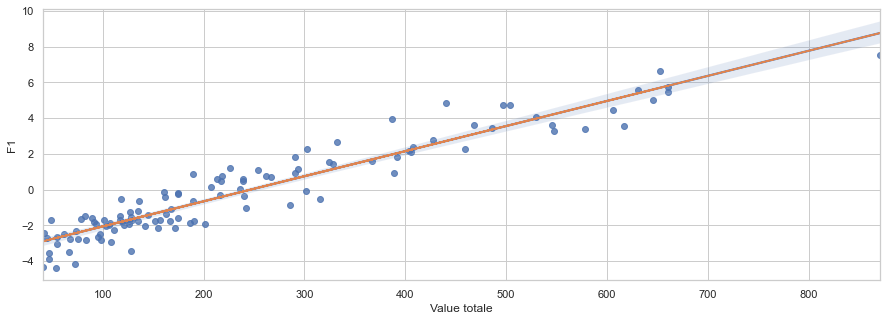

In [98]:
plt.figure(figsize=[15,5])
sns.regplot(x='Value totale',y='F1',data=all_value)
plt.plot(all_value['Value totale'],y_list_F1)
# corré_quant(all_value['Value totale'],all_value['F1'])
plt.show()

La fonction que nous avons obtenue est correcte puisque la trend du regplot et la fonction se superposent

In [99]:
all_value['trend'] = y_list_F1

In [100]:
all_value[all_value['Team'] == 'Fiorentina']

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2,trend
21,4,Fiorentina,2014,64,0.474,61,46,60.67,48.50,218,61.1,57.062,1.015123,1.034055,Européen,CL,0.729720,0.332111,-0.409374
22,5,Fiorentina,2015,64,0.474,60,42,53.19,36.22,190,71.4,30.250,1.036023,1.043734,Européen,EL,0.864443,0.263228,-0.802586
23,8,Fiorentina,2016,60,0.421,63,57,55.14,53.30,217,83.8,35.625,1.019231,1.057234,Non-Européen,NE,0.464638,-0.442027,-0.423418
24,8,Fiorentina,2017,57,0.421,54,46,54.12,42.15,236,95.1,34.188,1.007949,0.998856,Non-Européen,NE,0.036228,0.328729,-0.156595
25,14,Fiorentina,2018,41,0.211,47,45,54.12,44.08,315,99.9,61.438,0.993233,1.006819,Non-Européen,NE,-0.509430,-0.807964,0.952824
26,9,Fiorentina,2019,49,0.316,51,48,53.49,50.30,302,116.4,57.625,1.000602,0.993547,Non-Européen,NE,-0.101761,-0.395902,0.770262
27,13,Fiorentina,2020,40,0.237,47,59,46.20,62.02,286,106.2,56.000,1.011072,0.981915,Non-Européen,NE,-0.894442,-1.068691,0.545569


In [101]:
# plt.figure(figsize=[20,5])
# plt.subplot(121)
# list_trend = list(abs(all_value[all_value['Team'] == 'Arsenal']['trend']*10))
# list_value = list(abs(all_value[all_value['Team'] == 'Arsenal']['Value totale']/10))
# sns.lineplot(x='Years',y='Rank',data=all_value[all_value['Team'] == 'Arsenal'],label='Rank')
# sns.lineplot(x='Years',y=list_trend,data=all_value[all_value['Team'] == 'Arsenal'],label='trend')
# # sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
# plt.ylim(21,0)
# plt.subplot(122)

# sns.lineplot(x='Years',y='Value totale',data=all_value[all_value['Team'] == 'Arsenal'],label='Valeur totale')
# plt.show()

A partir des corrélations, on va va prévoir se baser sur 3 variables pour prévoir le futur classement du mhsc :
* Classement
* F1
* Valeur de l'effectif

In [102]:
all_value.columns

Index(['Rank', 'Team', 'Years', 'PTS', 'win_rate', 'G', 'GA', 'xG', 'xGA',
       'Value totale', 'Value attaque', 'Value défense', 'coef défense',
       'coef attaque', 'is_euro', 'is_euro_detail', 'F1', 'F2', 'trend'],
      dtype='object')

In [103]:
variables = all_value[['Team','Rank','F1','Value totale','Years','is_euro','is_euro_detail','trend','win_rate']]

In [104]:
list_value = []
for i in variables['Value totale']:
    if i < 80:
        list_value.append('> 80 m')
    elif (i >= 80)&(i < 150): 
        list_value.append('80 m < i < 150 m')
    elif (i >= 150)&(i < 250): 
        list_value.append('150 m < i < 250 m')
    elif (i >= 250)&(i < 400): 
        list_value.append('250 m < i < 400 m')
    elif (i >= 400)&(i < 600): 
        list_value.append('400 m < i < 600 m')
    elif i >= 600:
        list_value.append('> 600 m')
variables['ech_value'] = list_value

<ipython-input-104-4ffa28d6047d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables['ech_value'] = list_value


In [105]:
pal = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)


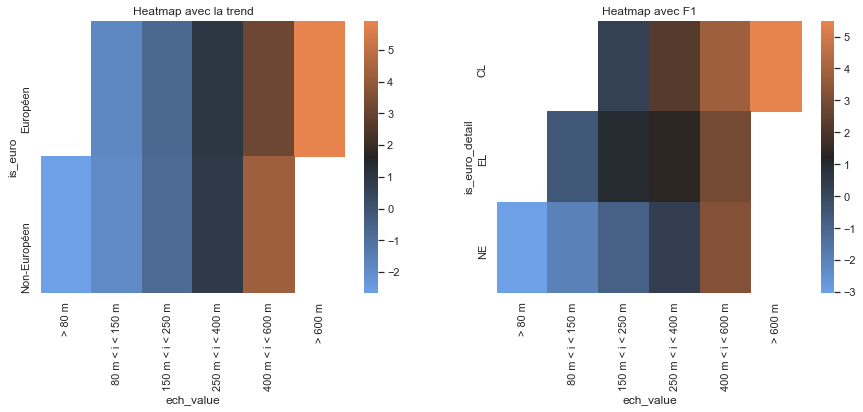

In [106]:
euro_var = variables.groupby(['is_euro','ech_value']).mean().reset_index()[['is_euro','ech_value','trend']].pivot(index='is_euro',columns='ech_value',values='trend')[['> 80 m','80 m < i < 150 m','150 m < i < 250 m','250 m < i < 400 m','400 m < i < 600 m','> 600 m']]
euro_detail_var = variables.groupby(['is_euro_detail','ech_value']).mean().reset_index()[['is_euro_detail','ech_value','trend']].pivot(index='is_euro_detail',columns='ech_value',values='trend')[['> 80 m','80 m < i < 150 m','150 m < i < 250 m','250 m < i < 400 m','400 m < i < 600 m','> 600 m']]
euro_var_F1 = variables.groupby(['is_euro','ech_value']).mean().reset_index()[['is_euro','ech_value','F1']].pivot(index='is_euro',columns='ech_value',values='F1')[['> 80 m','80 m < i < 150 m','150 m < i < 250 m','250 m < i < 400 m','400 m < i < 600 m','> 600 m']]
euro_detail_var_F1 = variables.groupby(['is_euro_detail','ech_value']).mean().reset_index()[['is_euro_detail','ech_value','F1']].pivot(index='is_euro_detail',columns='ech_value',values='F1')[['> 80 m','80 m < i < 150 m','150 m < i < 250 m','250 m < i < 400 m','400 m < i < 600 m','> 600 m']]
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.heatmap(euro_var,cmap=pal)
plt.title('Heatmap avec la trend')
plt.subplot(122)
sns.heatmap(euro_detail_var_F1,cmap=pal)
plt.title('Heatmap avec F1')
plt.show()
# plt.figure(figsize=[15,5])
# plt.subplot(121)
# sns.heatmap(euro_detail_var,cmap=pal)
# plt.title('Heatmap avec la trend')
# plt.subplot(122)
# sns.heatmap(euro_detail_var_F1,cmap=pal)
# plt.title('Heatmap avec F1')
# plt.show()

### Prédictions 

Régression logistique

K-Means

In [107]:
# <!-- * analyse de la variance -->

In [108]:
variables.head()

,Team,Rank,F1,Value totale,Years,is_euro,is_euro_detail,trend,win_rate,ech_value
1,Juventus,1,4.818276,440,2015,Européen,CL,2.708235,0.763,400 m < i < 600 m
2,Juventus,1,4.710369,497,2016,Européen,CL,3.508702,0.763,400 m < i < 600 m
3,Juventus,1,6.609037,653,2017,Européen,CL,5.699455,0.789,> 600 m
4,Juventus,1,7.510802,871,2018,Européen,CL,8.760891,0.737,> 600 m
5,Juventus,1,5.717768,661,2019,Européen,CL,5.811801,0.684,> 600 m


#### K-Means 

C:\Users\gormt\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


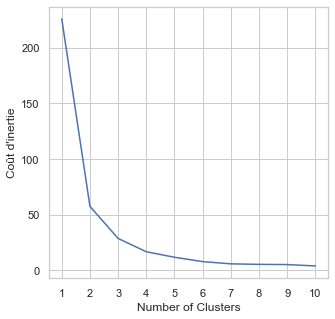

In [109]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import decomposition,preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid

data = variables[["trend","Value totale"]]
X = data.values
X_scaled = preprocessing.StandardScaler().fit_transform(X)

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    
fig_1 = plt.figure(figsize=(5,5))

#plt.style.use("fivethirtyeight")
sns.set(style="whitegrid")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Coût d'inertie")
plt.savefig('graph_cout_inert.png')
plt.show()

In [110]:
# Projection des individus
# Réduire  ici est nécessaire car les variables sont pas exprimées dans la même unité
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#X_projected = pca.transform(X_scaled)

# Clustering par K-means
# 2 clusters
km = KMeans(n_clusters=2)
km.fit(X_scaled)
y_means = km.predict(X_scaled)

km3 = KMeans(n_clusters=3)
km3.fit(X_scaled)
y_means3 = km3.predict(X_scaled)

clust_lab3 = km3.labels_

ValueError: 'c' argument has 113 elements, which is inconsistent with 'x' and 'y' with size 119.

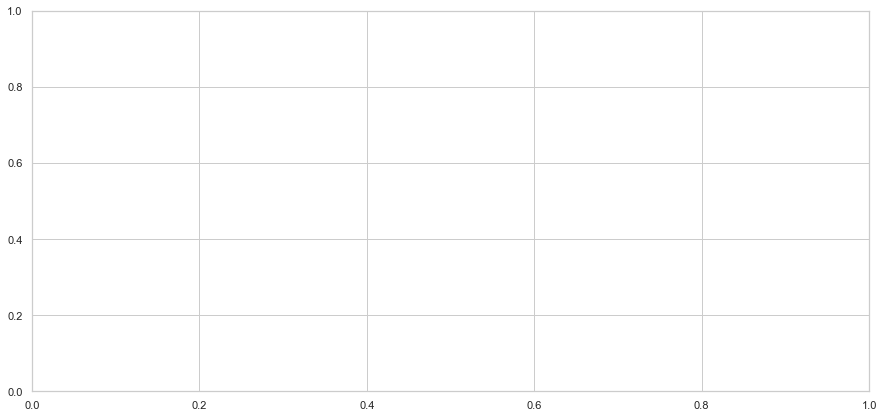

In [111]:
import matplotlib.patches as mpatches
# Visualisation de nos deux clusters dans le premier plan factoriel

plt.figure(figsize=(15, 7))

categories = km.labels_
colormap = np.array(['royalblue','coral'])
sns.set(style="whitegrid")
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[categories], 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

lab_0 = mpatches.Patch(color='royalblue', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='coral', alpha=0.5, label='1')
lab_2 = mpatches.Patch(color='grey', alpha=0.5, label='1')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)),fontsize='large')
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)),fontsize='large')
plt.title("Projection en 2 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.savefig('project_ind_kmeans.png')
plt.show()

plt.figure(figsize=(15, 7))
categories3 = km3.labels_
colormap = np.array(['royalblue','coral','grey'])
sns.set(style="whitegrid")
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[categories3], 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

lab_0 = mpatches.Patch(color='royalblue', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='coral', alpha=0.5, label='1')
lab_2 = mpatches.Patch(color='grey', alpha=0.5, label='2')
plt.legend(handles=[lab_0, lab_1, lab_2])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)),fontsize='large')
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)),fontsize='large')
plt.title("Projection en 3 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.savefig('project_ind_kmeans.png')
plt.show()

In [112]:
variables['clusters'] = categories
# variables['clusters_3'] = categories3

<ipython-input-112-10f62482c47d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables['clusters'] = categories


In [113]:
variables

,Team,Rank,F1,Value totale,Years,is_euro,is_euro_detail,trend,win_rate,ech_value,clusters
1,Juventus,1,4.818276,440,2015,Européen,CL,2.708235,0.763,400 m < i < 600 m,0
2,Juventus,1,4.710369,497,2016,Européen,CL,3.508702,0.763,400 m < i < 600 m,0
3,Juventus,1,6.609037,653,2017,Européen,CL,5.699455,0.789,> 600 m,0
4,Juventus,1,7.510802,871,2018,Européen,CL,8.760891,0.737,> 600 m,0
5,Juventus,1,5.717768,661,2019,Européen,CL,5.811801,0.684,> 600 m,0
...,...,...,...,...,...,...,...,...,...,...,...
114,Bologne,12,-1.709011,129,2019,Non-Européen,NE,-1.659227,0.316,80 m < i < 150 m,1
115,Bologne,12,-1.773605,152,2020,Non-Européen,NE,-1.336231,0.263,150 m < i < 250 m,1
116,Crotone,18,-3.911036,47,2017,Non-Européen,NE,-2.810776,0.237,> 80 m,1
117,SPAL,13,-2.479483,97,2018,Non-Européen,NE,-2.108612,0.289,80 m < i < 150 m,1


<AxesSubplot:xlabel='clusters', ylabel='is_euro'>

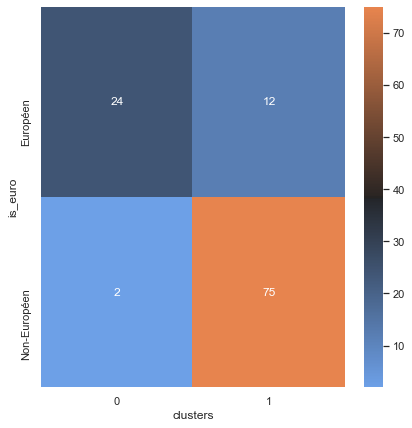

In [114]:
euro = pd.crosstab(variables['is_euro'], variables["clusters"],margins=True,margins_name='Total')
# euro_bis = pd.crosstab(variables['is_euro_detail'], variables["clusters_3"],margins=True,margins_name='Total')
plt.figure(figsize=(15, 7))
plt.subplot(121)
sns.heatmap(euro.iloc[0:2,0:-1],annot=True, cmap=pal)
# plt.subplot(122)
# sns.heatmap(euro_bis.iloc[0:3,0:-1],annot=True, cmap=pal)
# plt.show()

Résultat beaucoup trop approximatif pour le second K-Means

Cependant, on peut poursuivre l'analyse avec le premier K-Means dont les résultats sont pas si mauvais, seulement 5 faux-négatifs et faux-positifs

In [115]:
from sklearn.model_selection import train_test_split
variables_corr = variables[['Team','Rank','trend','Value totale','Years','is_euro','ech_value','clusters','win_rate']]
list_euro = []
for i in variables_corr['is_euro']:
    if i == 'Européen':
        list_euro.append(1)
    elif i == 'Non-Européen':
        list_euro.append(0)
variables_corr['is_euro'] = list_euro 
xtrain, xtest, ytrain, ytest = train_test_split(variables_corr[['trend']], variables_corr[['is_euro']], train_size=0.8)

<ipython-input-115-be139310768c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables_corr['is_euro'] = list_euro


In [116]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import pickle

modele_logit = LogisticRegression()
modele_logit.fit(xtrain,ytrain)
precision = modele_logit.score(xtest,ytest)

with open('model_mhsc.pkl', 'wb') as f:
    my_pickler = pickle.Pickler(f)
    my_pickler.dump(modele_logit)

C:\Users\gormt\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


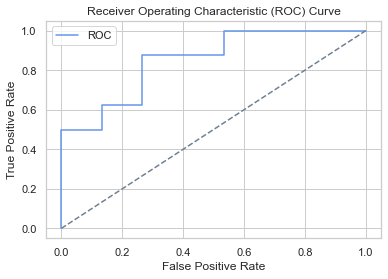

In [117]:
probs = modele_logit.predict_proba(xtest)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(ytest, probs) 
plot_roc_curve(fper, tper)

#### Matrice de confusion

In [118]:
variables_corr = variables_corr.reset_index()
ytest = ytest.reset_index()

In [119]:
variables_corr

,index,Team,Rank,trend,Value totale,Years,is_euro,ech_value,clusters,win_rate
0,1,Juventus,1,2.708235,440,2015,1,400 m < i < 600 m,0,0.763
1,2,Juventus,1,3.508702,497,2016,1,400 m < i < 600 m,0,0.763
2,3,Juventus,1,5.699455,653,2017,1,> 600 m,0,0.789
3,4,Juventus,1,8.760891,871,2018,1,> 600 m,0,0.737
4,5,Juventus,1,5.811801,661,2019,1,> 600 m,0,0.684
...,...,...,...,...,...,...,...,...,...,...
108,114,Bologne,12,-1.659227,129,2019,0,80 m < i < 150 m,1,0.316
109,115,Bologne,12,-1.336231,152,2020,0,150 m < i < 250 m,1,0.263
110,116,Crotone,18,-2.810776,47,2017,0,> 80 m,1,0.237
111,117,SPAL,13,-2.108612,97,2018,0,80 m < i < 150 m,1,0.289


In [120]:
data_predict = pd.merge(variables_corr,ytest,how = 'inner',on='index')
data_predict = data_predict.drop(['index'],axis=1)

In [121]:
data_predict

,Team,Rank,trend,Value totale,Years,is_euro_x,ech_value,clusters,win_rate,is_euro_y
0,Juventus,1,2.708235,440,2015,1,400 m < i < 600 m,0,0.763,1
1,Lazio,5,-0.297028,226,2016,1,150 m < i < 250 m,1,0.553,1
2,Fiorentina,4,-0.409374,218,2014,1,150 m < i < 250 m,1,0.474,1
3,Fiorentina,9,0.770262,302,2019,0,250 m < i < 400 m,1,0.316,0
4,Fiorentina,13,0.545569,286,2020,0,250 m < i < 400 m,1,0.237,0
5,Naples,5,3.972131,530,2020,1,400 m < i < 600 m,0,0.632,1
6,Genoa,6,-1.813703,118,2014,1,80 m < i < 150 m,1,0.421,1
7,Genoa,16,-1.954136,108,2016,0,80 m < i < 150 m,1,0.237,0
8,Sampdoria,7,-1.560924,136,2014,0,80 m < i < 150 m,1,0.342,0
9,Inter,4,0.657915,294,2015,1,250 m < i < 400 m,1,0.526,1


In [122]:
predict = pd.crosstab(data_predict['is_euro_x'], data_predict["is_euro_y"],rownames=['Actual'], colnames=['Predicted'],margins=True,margins_name='Total')

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

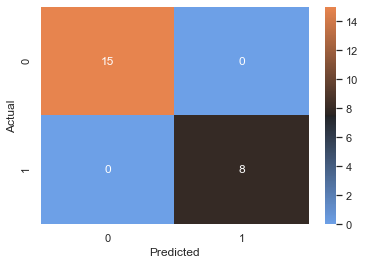

In [123]:
sns.heatmap(predict.iloc[0:2,0:-1],annot=True, cmap=pal)

In [124]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(' ')
print('Precision: %.3f' % precision_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))
print('Recall: %.3f' % recall_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))
print('Accuracy: %.3f' % accuracy_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))
print('F1 Score: %.3f' % f1_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))

 
Precision: 1.000
Recall: 1.000
Accuracy: 1.000
F1 Score: 1.000


In [125]:
print(sklearn.metrics.classification_report(data_predict['is_euro_x'], data_predict["is_euro_y"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         8

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



In [126]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.api import Logit
mode = Logit(endog=ytrain,exog=xtrain)
lr = mode.fit()

lr.summary()

Optimization terminated successfully.
         Current function value: 0.302048
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_euro   No. Observations:                   90
Model:                          Logit   Df Residuals:                       89
Method:                           MLE   Df Model:                            0
Date:                Thu, 19 Aug 2021   Pseudo R-squ.:                  0.5128
Time:                        18:30:00   Log-Likelihood:                -27.184
converged:                       True   LL-Null:                       -55.799
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          1.3808      0.276      5.000      0.000       0.840       1.922
==============================================================================
"""